Model orthogonalization with LDM variants (heavily based on Vojta's naive code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good models 10 bad models
* 1 pefect model, 3 good models, 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants: Data preparation
    └── PCA - Analysis

        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [14]:
# pip install corner

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner 



#Some colors that Pablo likes:
colors = [
    "#ff7f0e",

    "#1f77b4",

    "#2ca02c",
    "#d62728",
    
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 

markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]



def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)


    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 


# def LDM_extended(params, x): 
#     #x = (n,z)
#     #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
#     n=x[0]
#     z=x[1]
#     A = n + z
#     I = (n-z)/(n+z)


#     return A*(params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                 + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) )






# def LDM_extended(params, x): 
#     #x = (n,z)
#     #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
#     n=x[0]
#     z=x[1]
#     A = n + z
#     I = (n-z)/(n+z)


#     return params[0]*A**(params[7]) + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                 + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 





### Global variables####

# SkO values selected for the truth

truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 
GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1
BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]

# NL_1 
TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57]





# truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57,0]

# PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57,0]

# # SLy4 
# GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57,0.01]
# # NL_1
# BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57,0.03]

# # NL_1 
# TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57,0.05]






#Noise terms to be added to the parameters


params_noise_term_p=0.000
params_noise_term_g=0.002
params_noise_term_b=0.002
params_noise_term_t=0.002

# overall_output_noise=0.0005
overall_output_noise=0.005   # Noise added to each observation coming from models


overall_data_noise= 0.005  #Noise added to the "true" generated data itself



##########################


#Number used for when dividing training and testing randomly uniformly (interpolating)
TestingFraction=0.34

#Number used for when dividing training and testing by how close they are to the stable nuclei
distance=2



#Target nucleus: 
target_isotope=np.array([32,20])


#Coordinates to truncate so the LDM evaluations are not done below these isotopes
minimumZ=8
minimumN=8



centering_data=False

In [416]:
#Some functions for plotting capabilities

def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


def Plotter2D_single(data):
    xvals,yvals,zvals = data
    #A plotter to see principal components in 2D
    plt.rc("xtick", labelsize=25)
    plt.rc("ytick", labelsize=25)
    
    fig, ax = plt.subplots(figsize=(12, 8), dpi=200)

    # Create scatter plot
    sc = ax.scatter(xvals, yvals, c=zvals, s=25, cmap='plasma',marker='s')
    # plt.colorbar(sc, label='Z-Value')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Z-Value', fontsize=25) 
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel('Neutrons',fontsize=25)
    plt.ylabel('Protons',fontsize=25)

    ax.grid(True)
    # ax.axis('equal')

    plt.show()

def Plotter3D_single(data,elev=30,azim=-60):
    xvals,yvals,zvals = data
    #A plotter to see principal components in 3D
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15)

    z_min = zvals.min()
    z_max = zvals.max()
    z_normalized = (zvals - z_min) / (z_max - z_min)

    # Create figure for 3D plot
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_subplot(111, projection='3d')



    # Define the size of the bars
    dx = dy = 1.5  # Width of the bars in the x and y direction
    dz = z_normalized        # Height of the bars (z values)

    # Create 3D bar plot
    ax.bar3d(xvals, yvals, np.zeros_like(zvals), dx, dy, dz, color=plt.cm.plasma(z_normalized))

    ax.view_init(elev=elev, azim=azim) 

    # Setting labels and title
    ax.set_xlabel('Neutrons')
    ax.set_ylabel('Protons')
    ax.set_zlabel('Scaled Z')


    plt.show()    



def Plotter2D(ax,xvals,yvals,zvals):
    #A plotter to see principal components in 2D, part of the big plotter



    # Create scatter plot
    sc = ax.scatter(xvals, yvals, c=zvals, s=25, cmap='plasma',marker='s')
    # plt.colorbar(sc, label='Z-Value')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Z-Value', fontsize=25) 
    cbar.ax.tick_params(labelsize=20) 




    plt.xlabel('Neutrons',fontsize=25)
    plt.ylabel('Protons',fontsize=25)

    ax.grid(True)
    ax.axis('equal')

    # plt.show()

def Plotter3D(ax,xvals,yvals,zvals,elev=30,azim=-60):
    #A plotter to see principal components in 3D, part of the big plotter


    z_min = zvals.min()
    z_max = zvals.max()
    z_normalized = (zvals - z_min) / (z_max - z_min)

    # Create figure for 3D plot
    # fig = plt.figure(figsize=(8, 6), dpi=200)
    # ax = fig.add_subplot(111, projection='3d')



    # Define the size of the bars
    dx = dy = 1.5  # Width of the bars in the x and y direction
    dz = z_normalized        # Height of the bars (z values)

    # Create 3D bar plot
    ax.bar3d(xvals, yvals, np.zeros_like(zvals), dx, dy, dz, color=plt.cm.plasma(z_normalized))

    ax.view_init(elev=elev, azim=azim) 

    # Setting labels and title
    ax.set_xlabel('Neutrons')
    ax.set_ylabel('Protons')
    ax.set_zlabel('Scaled Z')


    # plt.show()    



def PlotMultiple(data_sets,angles_sheet=None):
    # Determine the number of rows needed for the plots
    n_rows = len(data_sets)
    # Each data_sets element should look like [x,y,z]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 8 * n_rows), dpi=200)

    for i, (xvals, yvals, zvals) in enumerate(data_sets):
        # 2D plot
        ax_2d = fig.add_subplot(n_rows, 2, 2 * i + 1)
        Plotter2D(ax_2d, xvals, yvals, zvals)

        # 3D plot
        ax_3d = fig.add_subplot(n_rows, 2, 2 * i + 2, projection='3d')
        if angles_sheet == None:
            Plotter3D(ax_3d, xvals, yvals, zvals)
        else:
            Plotter3D(ax_3d, xvals, yvals, zvals,elev=angles_sheet[0],azim=angles_sheet[1])

    plt.tight_layout()
    plt.show()



In [417]:
def separate_points_random(list1,random_chance):
    """
    Separates points in list1 into two groups randomly

    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]


    for i in range(len(list1)):
        point1=list1[i]
        val=np.random.rand()
        if val<=random_chance:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [418]:
def separate_points_distance(list1, list2, distance):
    """
    Separates points in list1 into two groups based on their proximity to any point in list2.

    :param list1: List of (x, y) tuples.
    :param list2: List of (x, y) tuples.
    :param distance: The threshold distance to determine proximity.
    :return: Two lists - close_points and distant_points.
    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]

    for i in range(len(list1)):
        point1=list1[i]
        close = False
        for point2 in list2:
            if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance:
                close = True
                break
        if close:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [419]:
def separate_points_distance_allSets(list1, list2, distance1, distance2):
    """
    Separates points in list1 into three groups based on their proximity to any point in list2.

    :param list1: List of (x, y) tuples.
    :param list2: List of (x, y) tuples.
    :param distance: The threshold distance to determine proximity.
    :return: Two lists - close_points and distant_points.
    """
    train = []
    validation=[]
    test = []

    train_list_coordinates=[]
    validation_list_coordinates=[]
    test_list_coordinates=[]

    for i in range(len(list1)):
        point1=list1[i]
        close = False
        for point2 in list2:
            if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance1:
                close = True
                break
        if close:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            close2=False
            for point2 in list2:
                if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance2:
                    close2 = True
                    break
            if close2==True:
                validation.append(point1)
                validation_list_coordinates.append(i)
            else:
                test.append(point1)
                test_list_coordinates.append(i)                

    return np.array(train),np.array(validation), np.array(test), np.array(train_list_coordinates),  np.array(validation_list_coordinates),np.array(test_list_coordinates)


In [420]:
stable_coordinates_full=np.loadtxt("Stable-Isotopes.txt")

In [421]:
stable_coordinates=[]

for i in range(len(stable_coordinates_full)):
    if (stable_coordinates_full[i][0]>=minimumN) & (stable_coordinates_full[i][1]>=minimumZ) & (stable_coordinates_full[i][0]% 2 == 0) & (stable_coordinates_full[i][1]% 2 == 0) :
        stable_coordinates.append(stable_coordinates_full[i])

stable_coordinates=np.array(stable_coordinates)

In [422]:
Full_set_2003=np.loadtxt("AME2003.txt")
Full_set_2016=np.loadtxt("AME2016.txt")
Full_set_2020=np.loadtxt("AME2020.txt")

In [423]:
AME2003_even=[]


for i in range(len(Full_set_2003)):
    if (Full_set_2003[i][0]>=minimumN) & (Full_set_2003[i][1]>=minimumZ) & (Full_set_2003[i][0]% 2 == 0) & (Full_set_2003[i][1]% 2 == 0) :
        AME2003_even.append([Full_set_2003[i][0],Full_set_2003[i][1]])

AME2003_even=np.array(AME2003_even)

In [424]:
AME2016_even=[]


for i in range(len(Full_set_2016)):
    if (Full_set_2016[i][0]>=minimumN) & (Full_set_2016[i][1]>=minimumZ) & (Full_set_2016[i][0]% 2 == 0) & (Full_set_2016[i][1]% 2 == 0) :
        AME2016_even.append([Full_set_2016[i][0],Full_set_2016[i][1]])

AME2016_even=np.array(AME2016_even)

In [425]:
AME2020_even=[]


for i in range(len(Full_set_2020)):
    if (Full_set_2020[i][0]>=minimumN) & (Full_set_2020[i][1]>=minimumZ) & (Full_set_2020[i][0]% 2 == 0) & (Full_set_2020[i][1]% 2 == 0) :
        AME2020_even.append([Full_set_2020[i][0],Full_set_2020[i][1]])

AME2020_even=np.array(AME2020_even)

In [426]:
Full_set=np.copy(AME2020_even)

In [427]:
# #Separating randomly
# np.random.seed(142857)
# training_set, testing_set, train_coordinates, test_coordinates=separate_points_random(Full_set, TestingFraction)


In [428]:
#Separating using the proximity to the stable isotopes. naively we only had two sets, so we have to make a tiny work-around to define
#the train and validation coordinates in one more step with respect to the full-set (AME2020)




# training_set, validation_set, train_coordinates0, validation_coordinates0=separate_points_distance(AME2003_even, stable_coordinates, distance)

In [429]:
distance1=2
distance2=3

training_set, validation_set, test_set,train_coordinates0, validation_coordinates0,test_coordinates0=separate_points_distance_allSets(AME2020_even, stable_coordinates, distance1,distance2)

In [430]:
train_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(training_set)):
       train_isotope=training_set[j]
       if (isotope2020[0]==train_isotope[0]) & (isotope2020[1]==train_isotope[1]):
           train_coordinates.append(i)
           break
train_coordinates=np.array(train_coordinates)

In [431]:
validation_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(validation_set)):
       validation_isotope=validation_set[j]
       if (isotope2020[0]==validation_isotope[0]) & (isotope2020[1]==validation_isotope[1]):
           validation_coordinates.append(i)
           break
validation_coordinates=np.array(validation_coordinates)

In [432]:
test_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(test_set)):
       test_isotope=test_set[j]
       if (isotope2020[0]==test_isotope[0]) & (isotope2020[1]==test_isotope[1]):
           test_coordinates.append(i)
           break
test_coordinates=np.array(test_coordinates)

In [433]:
# test_set=[]
# test_coordinates=[]

# for i in range(len(AME2020_even)):
#     isotope2020=AME2020_even[i]
#     for isotope2003 in AME2003_even:
#         flag=0
#         if (isotope2020[0]==isotope2003[0]) & (isotope2020[1]==isotope2003[1]):
#             flag=1
#             break
#     if flag==0:
#         test_set.append(isotope2020)
#         test_coordinates.append(i)
        


# test_set=np.array(test_set)
# test_coordinates=np.array(test_coordinates)



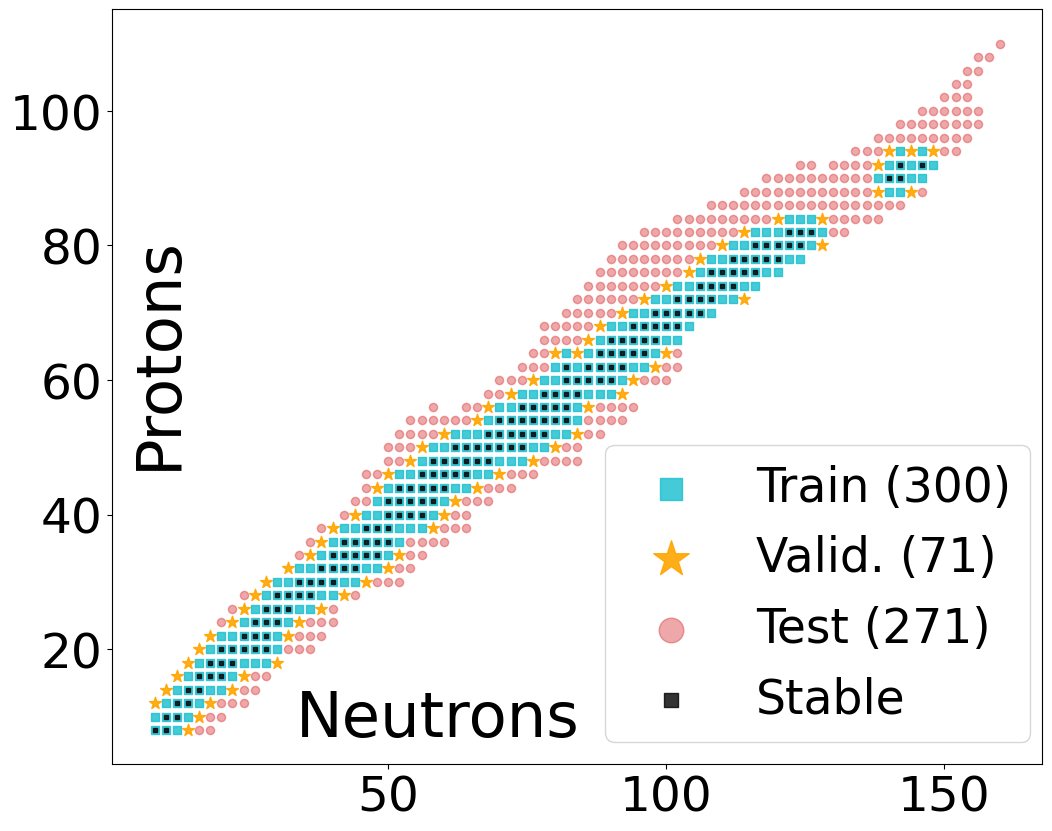

In [434]:
plt.rc("xtick", labelsize=35)
plt.rc("ytick", labelsize=35)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


color_trainig=colors[9]
color_validation='orange'
color_testing=colors[3]

marker_trainig='s'
marker_validation='*'
marker_testing='o'



size_trainig=30
size_validation=80
size_testing=35

alpha_trainig=0.8
alpha_validation=0.9
alpha_testing=0.4



ax.scatter(x = training_set.T[0], y = training_set.T[1], label = "Train ("+ str(len(training_set))+")", alpha = alpha_trainig,color=color_trainig,s=size_trainig,marker=marker_trainig)

ax.scatter(x = validation_set.T[0], y = validation_set.T[1], label = "Valid. (" + str(len(validation_set))+")", alpha = alpha_validation,color=color_validation,s=size_validation,marker=marker_validation)

ax.scatter(x = test_set.T[0], y = test_set.T[1], label = "Test (" + str(len(test_set))+")", alpha = alpha_testing,color=color_testing,s=size_testing,marker=marker_testing)


ax.scatter(x = stable_coordinates.T[0], y = stable_coordinates.T[1], label = "Stable", alpha = 0.8,color='black',s=11,marker="s")







# plt.xlabel("Neutrons",fontsize=45, labelpad=-20)


plt.xlabel('')

plt.annotate('Neutrons', xy=(0.35, 0.1), xycoords='axes fraction',
             ha='center', va='top', fontsize=45) 
plt.ylabel('')

plt.annotate('Protons', xy=(0.05,0.7), xycoords='axes fraction',
             ha='center', va='top', fontsize=45,rotation =90) 


# plt.ylabel("Protons",fontsize=45)
plt.legend(fontsize=34,markerscale=3 ,loc =(0.53,0.03))
plt.show()

In [435]:

# scenario = "1g1b"
# scenario = "3g10b"
# scenario = "1p3g10b"
# Fix random seed

# n_perfect =0
# n_good = 0
# n_bad = 0
# n_terrible=5


n_perfect =0
n_good = 3
n_bad = 5
n_terrible=10

n_classes=[n_perfect,n_good,n_bad,n_terrible]
# n_Labels=["Perfect Model", "Good Models", "Inter. Models","Bad Models"]
n_Labels=["Perfect M.", "Good M.", "Inter. M.","Bad M."]







# masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 

models_output = {}
models_output_train = {}
models_output_validation = {}
models_output_test = {}

models_output_target=[]






# #Option 1: Constructing the data by adding a random noise to the output of the models
# #Perfect Models Loop
# params = PerfectM_params
# for i in range(n_perfect):
#     models_output[str("PerfectModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_p


# #Good Models Loop
# params = GoodM_params
# for i in range(n_good):
#     models_output[str("GoodModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_g

# #Bad Models Loop
# params = BadM_params
# for i in range(n_bad):
#     models_output[str("IntermediateModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_b

# #Terrible Models Loop
# params = TerribleM_params
# for i in range(n_terrible):
#     models_output[str("BadModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_t






#Option 2: Constructing the data by adding a random noise to the parameters of the models
#Perfect Models Loop
np.random.seed(142857)
params = PerfectM_params
for i in range(n_perfect):
    ran_params=params + np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_p
    models_output[str("PerfectModel_")+str(i)] = LDM_extended(ran_params,Full_set.T)+np.random.normal(0,1,size=len(Full_set)) * overall_output_noise


    # models_output_target[str("PerfectModel_")+str(i)] = LDM_extended(ran_params
    #                                                           ,target_isotope)
    models_output_target.append(LDM_extended(ran_params,target_isotope)+ np.random.normal(0,1,size=1) * overall_output_noise)


# special_param=6    

#Good Models Loop
np.random.seed(542857)
params = GoodM_params
for i in range(n_good):

    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_g

    # ran_params[special_param]=0

    models_output[str("GoodModel_")+str(i)] = LDM_extended(ran_params
                                                           ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    # models_output_target[str("GoodModel_")+str(i)] = LDM_extended(ran_params ,target_isotope)
    models_output_target.append(LDM_extended(ran_params ,target_isotope)+ np.random.normal(0,1,size=1) * overall_output_noise)



#Bad Models Loop
np.random.seed(342857)
params = BadM_params
for i in range(n_bad):
    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_b
    # ran_params[special_param]=0

    models_output[str("IntermediateModel_")+str(i)] = LDM_extended(ran_params,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    
    # models_output_target[str("IntermediateModel_")+str(i)] = LDM_extended(ran_params ,target_isotope)
    models_output_target.append(LDM_extended(ran_params ,target_isotope)+ np.random.normal(0,1,size=1) * overall_output_noise)

    



#Terrible Models Loop
np.random.seed(442857)
params = TerribleM_params
for i in range(n_terrible):
    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_t

    # ran_params[special_param]=0
    models_output[str("BadModel_")+str(i)] = LDM_extended(ran_params
                                                          ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    
    # models_output_target[str("BadModel_")+str(i)] = LDM_extended(ran_params,target_isotope)
    models_output_target.append(LDM_extended(ran_params,target_isotope)+ np.random.normal(0,1,size=1) * overall_output_noise)




#This is done here to have a list of pure models, without the ground truth
key_list=list(models_output.keys())
np.random.seed(7*142857)
models_output['truth']=LDM_extended(truth_params,Full_set.T) + np.random.normal(0,1,size=len(Full_set))*overall_data_noise


models_output = pd.DataFrame(models_output)
models_output["N"] = Full_set.T[0]
models_output["Z"] = Full_set.T[1]
models_output["A"] = models_output["N"] + models_output["Z"]

models_output_target=np.array(models_output_target)
models_output_target_mean=np.mean(models_output_target)






In [436]:

models_output_train = models_output.iloc[train_coordinates]

models_output_validation = models_output.iloc[validation_coordinates]

models_output_test = models_output.iloc[test_coordinates]

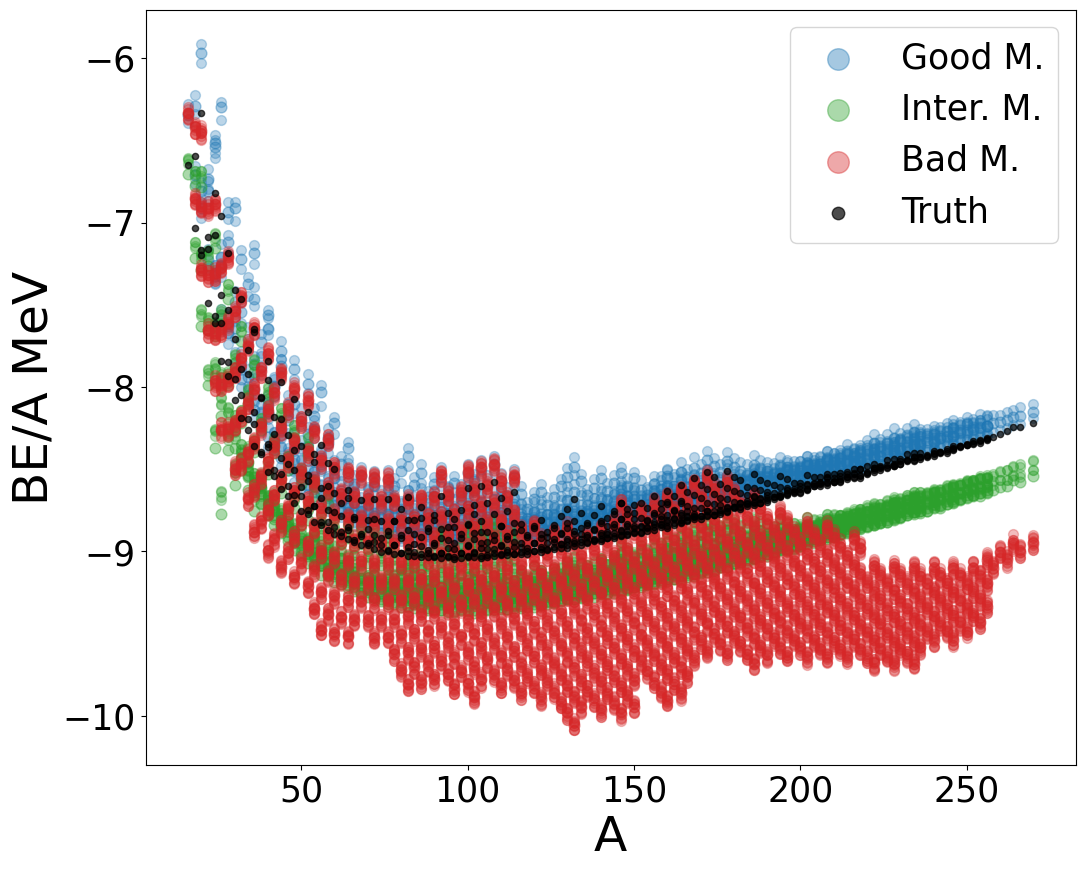

In [437]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output["A"], y = models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )

plt.show()

In [438]:
residuals = models_output['truth'].values[:,None] - models_output[key_list].values 

residuals_train = models_output_train['truth'].values[:,None] - models_output_train[key_list].values 

residuals_validation  = models_output_validation['truth'].values[:,None] - models_output_validation[key_list].values 

residuals_test  = models_output_test['truth'].values[:,None] - models_output_test[key_list].values 



model_predictions=models_output[key_list].values
model_predictions_train=models_output_train[key_list].values
model_predictions_validation=models_output_validation[key_list].values
model_predictions_test=models_output_test[key_list].values






model_summary = {}
model_summary["rmse_all"] = np.sqrt(np.mean(residuals ** 2, axis = 0))
model_summary["rmse_train"] = np.sqrt(np.mean(residuals_train ** 2, axis = 0))
model_summary["rmse_validation"] = np.sqrt(np.mean(residuals_validation ** 2, axis = 0))
model_summary["rmse_test"] = np.sqrt(np.mean(residuals_test ** 2, axis = 0))


model_summary_df = pd.DataFrame(model_summary, index =key_list)
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                     rmse_all  rmse_train  rmse_validation  rmse_test
GoodModel_0          0.148716    0.143722         0.171979   0.147577
GoodModel_1          0.101454    0.093797         0.124102   0.103004
GoodModel_2          0.197228    0.196139         0.222384   0.191332
IntermediateModel_0  0.357591    0.315705         0.354176   0.399660
IntermediateModel_1  0.272951    0.228735         0.269050   0.315614
IntermediateModel_2  0.268349    0.223581         0.264172   0.311405
IntermediateModel_3  0.311422    0.269337         0.306080   0.353419
IntermediateModel_4  0.318688    0.276220         0.313291   0.361142
BadModel_0           0.611331    0.533750         0.580987   0.693936
BadModel_1           0.582782    0.506088         0.553851   0.663850
BadModel_2           0.608663    0.530705         0.578138   0.691586
BadModel_3           0.604920    0.528127         0.574039   0.686868
BadModel_4           0.639541    0.560801         0.607447   0.723965
BadModel_5          

In [439]:
model_summary_df

rmse_all  rmse_train  rmse_validation  rmse_test
GoodModel_0          0.148716    0.143722         0.171979   0.147577
GoodModel_1          0.101454    0.093797         0.124102   0.103004
GoodModel_2          0.197228    0.196139         0.222384   0.191332
IntermediateModel_0  0.357591    0.315705         0.354176   0.399660
IntermediateModel_1  0.272951    0.228735         0.269050   0.315614
IntermediateModel_2  0.268349    0.223581         0.264172   0.311405
IntermediateModel_3  0.311422    0.269337         0.306080   0.353419
IntermediateModel_4  0.318688    0.276220         0.313291   0.361142
BadModel_0           0.611331    0.533750         0.580987   0.693936
BadModel_1           0.582782    0.506088         0.553851   0.663850
BadModel_2           0.608663    0.530705         0.578138   0.691586
BadModel_3           0.604920    0.528127         0.574039   0.686868
BadModel_4           0.639541    0.560801         0.607447   0.723965
BadModel_5           0.594326    0.516795         0.564333   0.676530
BadModel_6           0.634318    0.555701         0.602920   0.718403
BadModel_7           0.642987    0.565710         0.610390   0.726317
BadModel_8           0.587956    0.512297         0.557316   0.668608
BadModel_9           0.621443    0.543878         0.589666   0.704511

In [440]:
Selected_element=50
Selected_element_name="Sn"

Z_range=(Selected_element,Selected_element)
N_range=(0,300)


filtered_models_output = models_output[(models_output['Z'] >= Z_range[0]) & (models_output['Z'] <= Z_range[1]) & 
                     (models_output['N'] >= N_range[0]) & (models_output['N'] <= N_range[1])]

filtered_models_output_train = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'] >= N_range[0]) & (models_output_train['N'] <= N_range[1])]

filtered_models_output_test = models_output_test[(models_output_test['Z'] >= Z_range[0]) & (models_output_test['Z'] <= Z_range[1]) & 
                     (models_output_test['N'] >= N_range[0]) & (models_output_test['N'] <= N_range[1])]

filtered_models_output_validation = models_output_validation[(models_output_validation['Z'] >= Z_range[0]) & (models_output_validation['Z'] <= Z_range[1]) & 
                     (models_output_validation['N'] >= N_range[0]) & (models_output_validation['N'] <= N_range[1])]


stable_selected_isotope=[]

for i in range(len(stable_coordinates)):
    if stable_coordinates[i][1]==Selected_element:
        stable_selected_isotope.append(stable_coordinates[i])

stable_selected_isotope=np.array(stable_selected_isotope)

# df[df['Column1'].isin(values_array)]

filtered_models_output_stable = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'].isin(stable_selected_isotope.T[0]))]

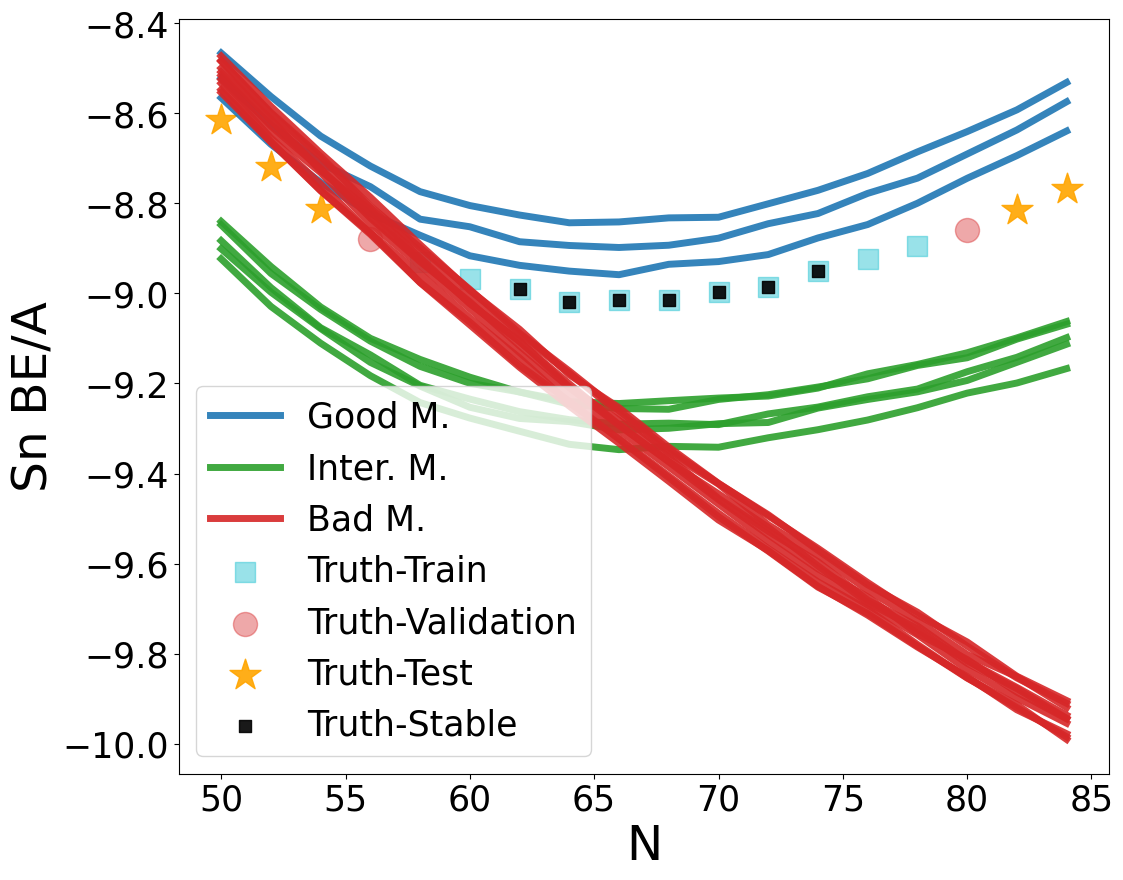

In [441]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0


# ax.scatter(x = training_set.T[0], y = training_set.T[1], label = "Training ("+ str(len(training_set))+")", alpha = 0.44,color=colors[1],s=40,marker="s")



# ax.scatter(x = validation_set.T[0], y = validation_set.T[1], label = "Validation (" + str(len(validation_set))+")", alpha = 0.4,color=colors[3],s=45,marker="o")


# ax.scatter(x = test_set.T[0], y = test_set.T[1], label = "Test (" + str(len(test_set))+")", alpha = 0.9,color='orange',s=90,marker="*")


# ax.scatter(x = stable_coordinates.T[0], y = stable_coordinates.T[1], label = "Stable", alpha = 0.8,color='black',s=13,marker="s")





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth-Train",  alpha = 0.44,color=colors[9],s=200,marker="s")

ax.scatter(x = filtered_models_output_validation["N"], y = filtered_models_output_validation['truth'], label = "Truth-Validation", alpha = 0.4,color=colors[3],s=300,marker="o")

ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'], label = "Truth-Test", alpha = 0.9,color='orange',s=550,marker="*")

ax.scatter(x = filtered_models_output_stable["N"], y = filtered_models_output_stable['truth'], label = "Truth-Stable", alpha = 0.9,color='k',s=80,marker="s")

plt.xlabel("N",fontsize=35)
plt.ylabel(Selected_element_name+" BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=1 )

plt.show()

## PCA - Analysis

In [442]:
predictions_mean= np.mean(model_predictions, axis=1)
predictions_train_mean= np.mean(model_predictions_train, axis=1)
predictions_validation_mean= np.mean(model_predictions_validation, axis=1)
predictions_test_mean= np.mean(model_predictions_test, axis=1)

In [443]:
if centering_data:
    model_predictions_train_processed=np.array([model_predictions_train.T[j]-predictions_train_mean for j in range(len(model_predictions_train.T))]).T
else:
    model_predictions_train_processed=np.copy(model_predictions_train)



In [444]:
U, S, Vt = np.linalg.svd(model_predictions_train_processed)

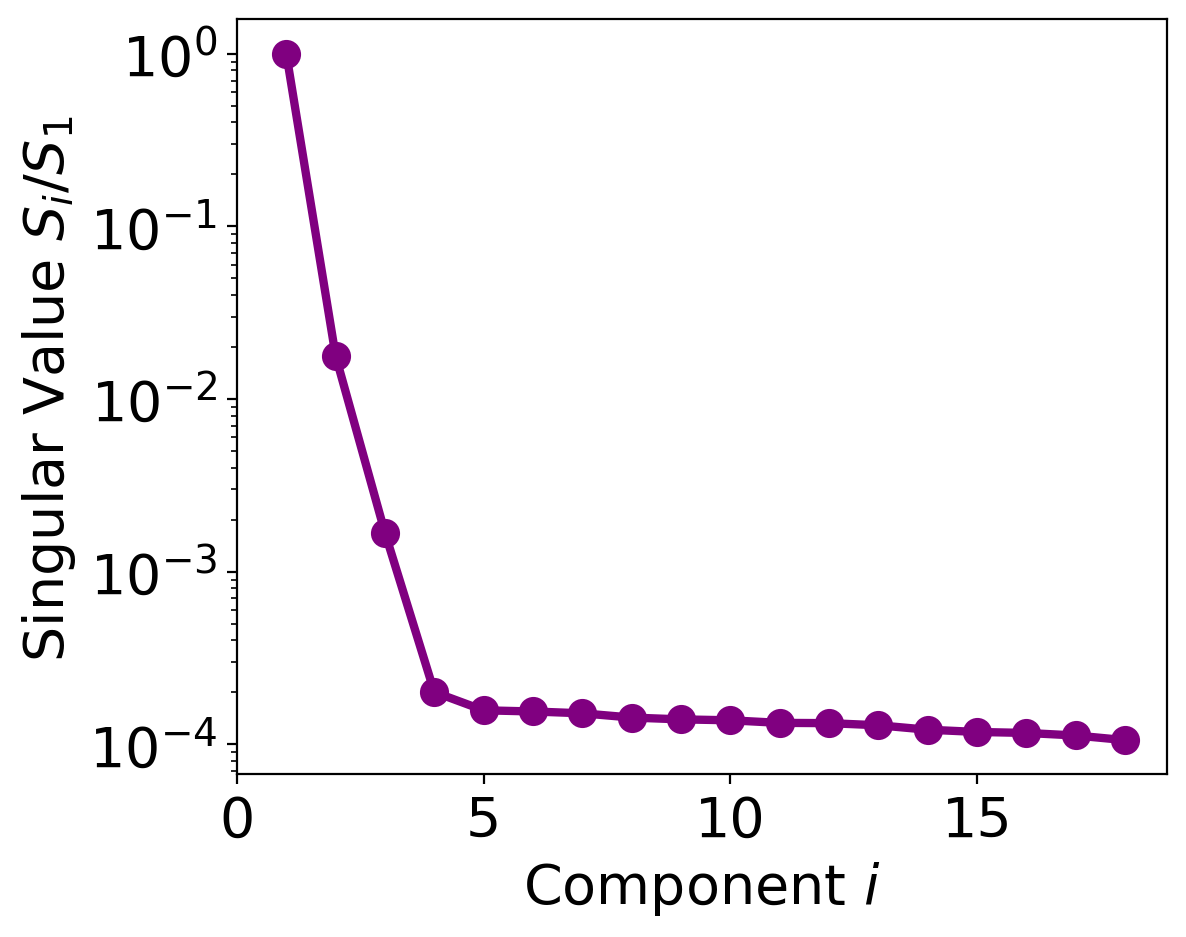

In [445]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(figsize=(6,5),dpi=200)
fig.patch.set_facecolor('white')

#We plot only up to n-1 singular values if we centered the data because the nth value is numerical noise ~10**(-15)
if centering_data:
    ax.scatter(np.arange(1,S.size), S[0:-1]/S[0],color='purple',s=90)
    ax.plot(np.arange(1,S.size), S[0:-1]/S[0],color='purple',linewidth=3)
else:
    ax.scatter(np.arange(1,S.size+1), S/S[0],color='purple',s=90)
    ax.plot(np.arange(1,S.size+1), S/S[0],color='purple',linewidth=3)    

ax.set_yscale('log')
ax.set_xlabel(r'Component $i$',fontsize=20)
ax.set_ylabel(r' Singular Value $S_i/S_1$',fontsize=20);
# plt.ylim(2*10**(-3),1.5)
ax.set_xticks([0,5,10,15])
# plt.title("Singular values decay",fontsize=30)
plt.show()

In [465]:
components_kept=3
S_hat=np.array([S[i] for i in range(components_kept)])


#No scalling at all:
# U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])
U_hat=np.array([U.T[i] for i in range(components_kept)])
Vt_hat=np.array([Vt[i]/S[i] for i in range(components_kept)])
Vt_hat_normalized=np.array([Vt[i] for i in range(components_kept)])

#Scaling manually:
# U_hat=np.array([U.T[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])
# #This represents the coefficients that we use to write the normalized PC everywhere as linear combinations of the original models. It is scaled by 
# # the values of S_hat such that the norm of the PC keeps ~ constant even as we increase the number of models
# Vt_hat=np.array([Vt[i]/S_hat[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])   
# #These are the normalized coefficients (norm[Vt_hat_normalized[i]] is 1). We use this to plot PC projections to distinguish between clusters of models
# Vt_hat_normalized=np.array([Vt[i] for i in range(components_kept)])







if centering_data:
    num_components=components_kept+1
else:
    num_components=components_kept


In [448]:
#Creating principal components that are for training. These should be equivalent to \hat U, and if they are not there is something wrong



models_PC_train = {}

if centering_data:
    models_PC_train[str("PC_0")] = predictions_train_mean
    
for i in range(components_kept):
    models_PC_train[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_train.T)

models_PC_train["N"] = models_output_train["N"]
models_PC_train["Z"] = models_output_train["Z"]
models_PC_train["A"] = models_PC_train["N"] + models_PC_train["Z"]

models_PC_training = pd.DataFrame(models_PC_train)



In [449]:
#Creating principal components that are for validation



models_PC_validation = {}

if centering_data:
    models_PC_validation[str("PC_0")] = predictions_validation_mean
    
for i in range(components_kept):
    models_PC_validation[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_validation.T)

models_PC_validation["N"] = models_output_validation["N"]
models_PC_validation["Z"] = models_output_validation["Z"]
models_PC_validation["A"] = models_PC_validation["N"] + models_PC_validation["Z"]

models_PC_validation = pd.DataFrame(models_PC_validation)



In [450]:
#Creating principal components that are for testing



models_PC_testing = {}

if centering_data:
    models_PC_testing[str("PC_0")] = predictions_test_mean
for i in range(components_kept):
    # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
    models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

models_PC_testing["N"] = models_output_test["N"]
models_PC_testing["Z"] = models_output_test["Z"]
models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]

models_PC_testing = pd.DataFrame(models_PC_testing)






In [451]:
#Creating principal components that are valid everywhere (testing + training + validation)
models_PC = {}

if centering_data:
    models_PC[str("PC_0")] = predictions_mean

for i in range(components_kept):
    models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)

models_PC = pd.DataFrame(models_PC)
models_PC["N"] = Full_set.T[0]
models_PC["Z"] = Full_set.T[1]
models_PC["A"] = models_PC["N"] + models_PC["Z"]

In [452]:
filtered_models_PC = models_PC[(models_PC['Z'] >= Z_range[0]) & (models_PC['Z'] <= Z_range[1]) & 
                     (models_PC['N'] >= N_range[0]) & (models_PC['N'] <= N_range[1])]

In [453]:
key_list_PCs=list(filtered_models_PC.keys())

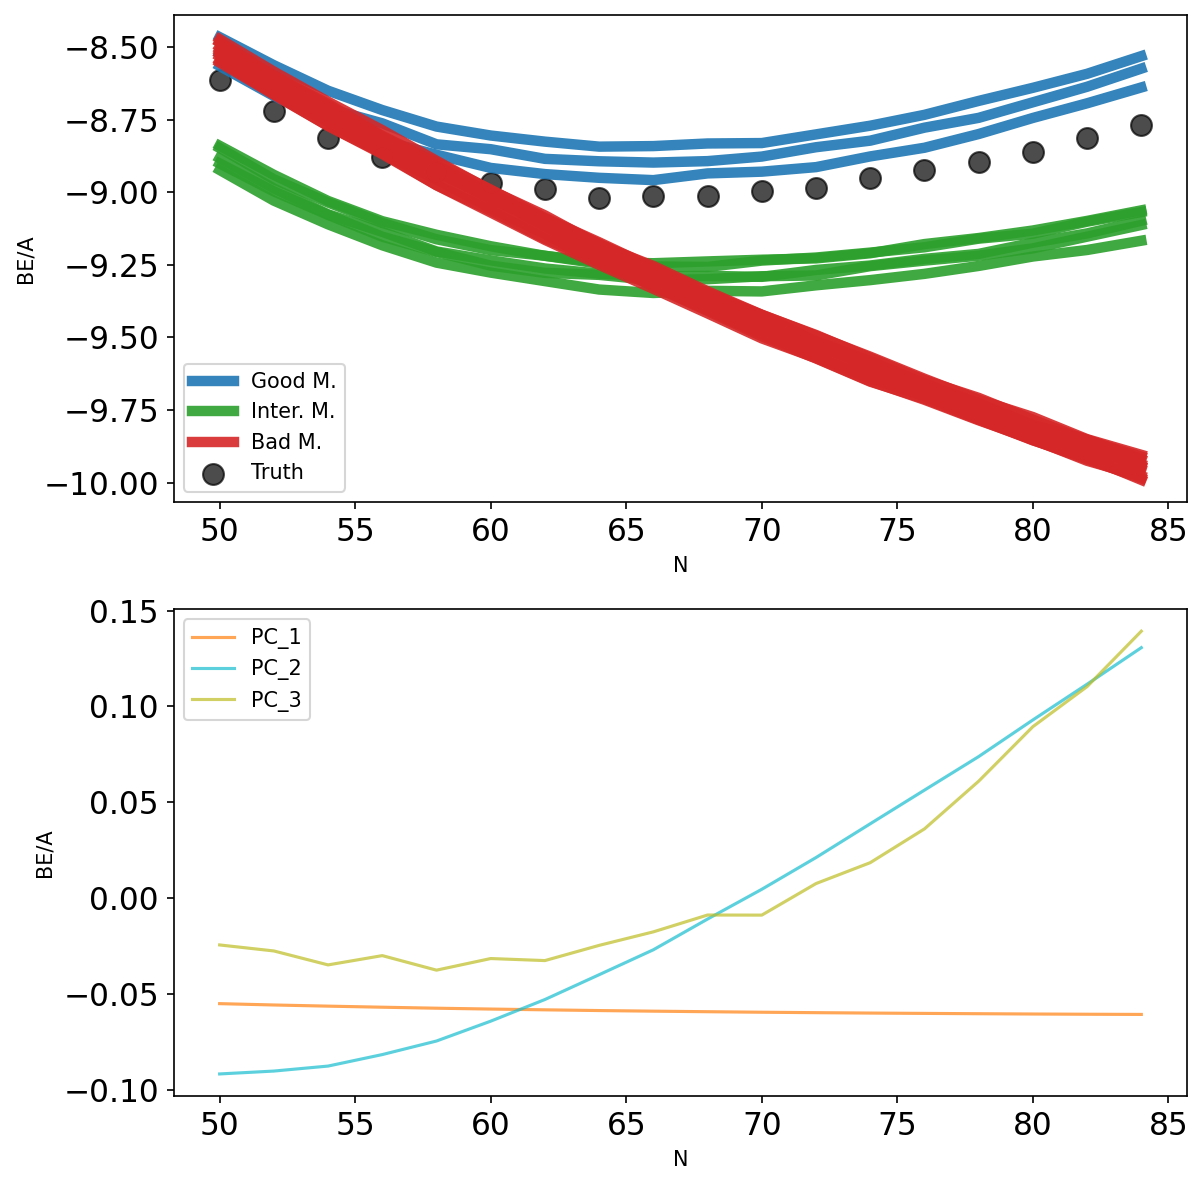

In [454]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# fig, ax = plt.subplots(figsize=(12,10), dpi=100)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8),dpi=150)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0

ax1.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=100)

ax1.set_xlabel("N")
ax1.set_ylabel("BE/A")
ax1.legend( )







for i in range(num_components):
    ax2.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])

ax2.set_xlabel("N")
ax2.set_ylabel("BE/A")
ax2.legend()





plt.tight_layout()

plt.show()

In [455]:
x_values=models_PC["N"].tolist()
y_values=models_PC["Z"].tolist()
pc_data=[]

if centering_data:
    pc_data.append([x_values,y_values,models_PC["PC_0"].tolist()])

for i in range(components_kept):
    pc_data.append([x_values,y_values,models_PC[str("PC_")+str(i+1)].tolist()])

    
pc_data=np.array(pc_data)    

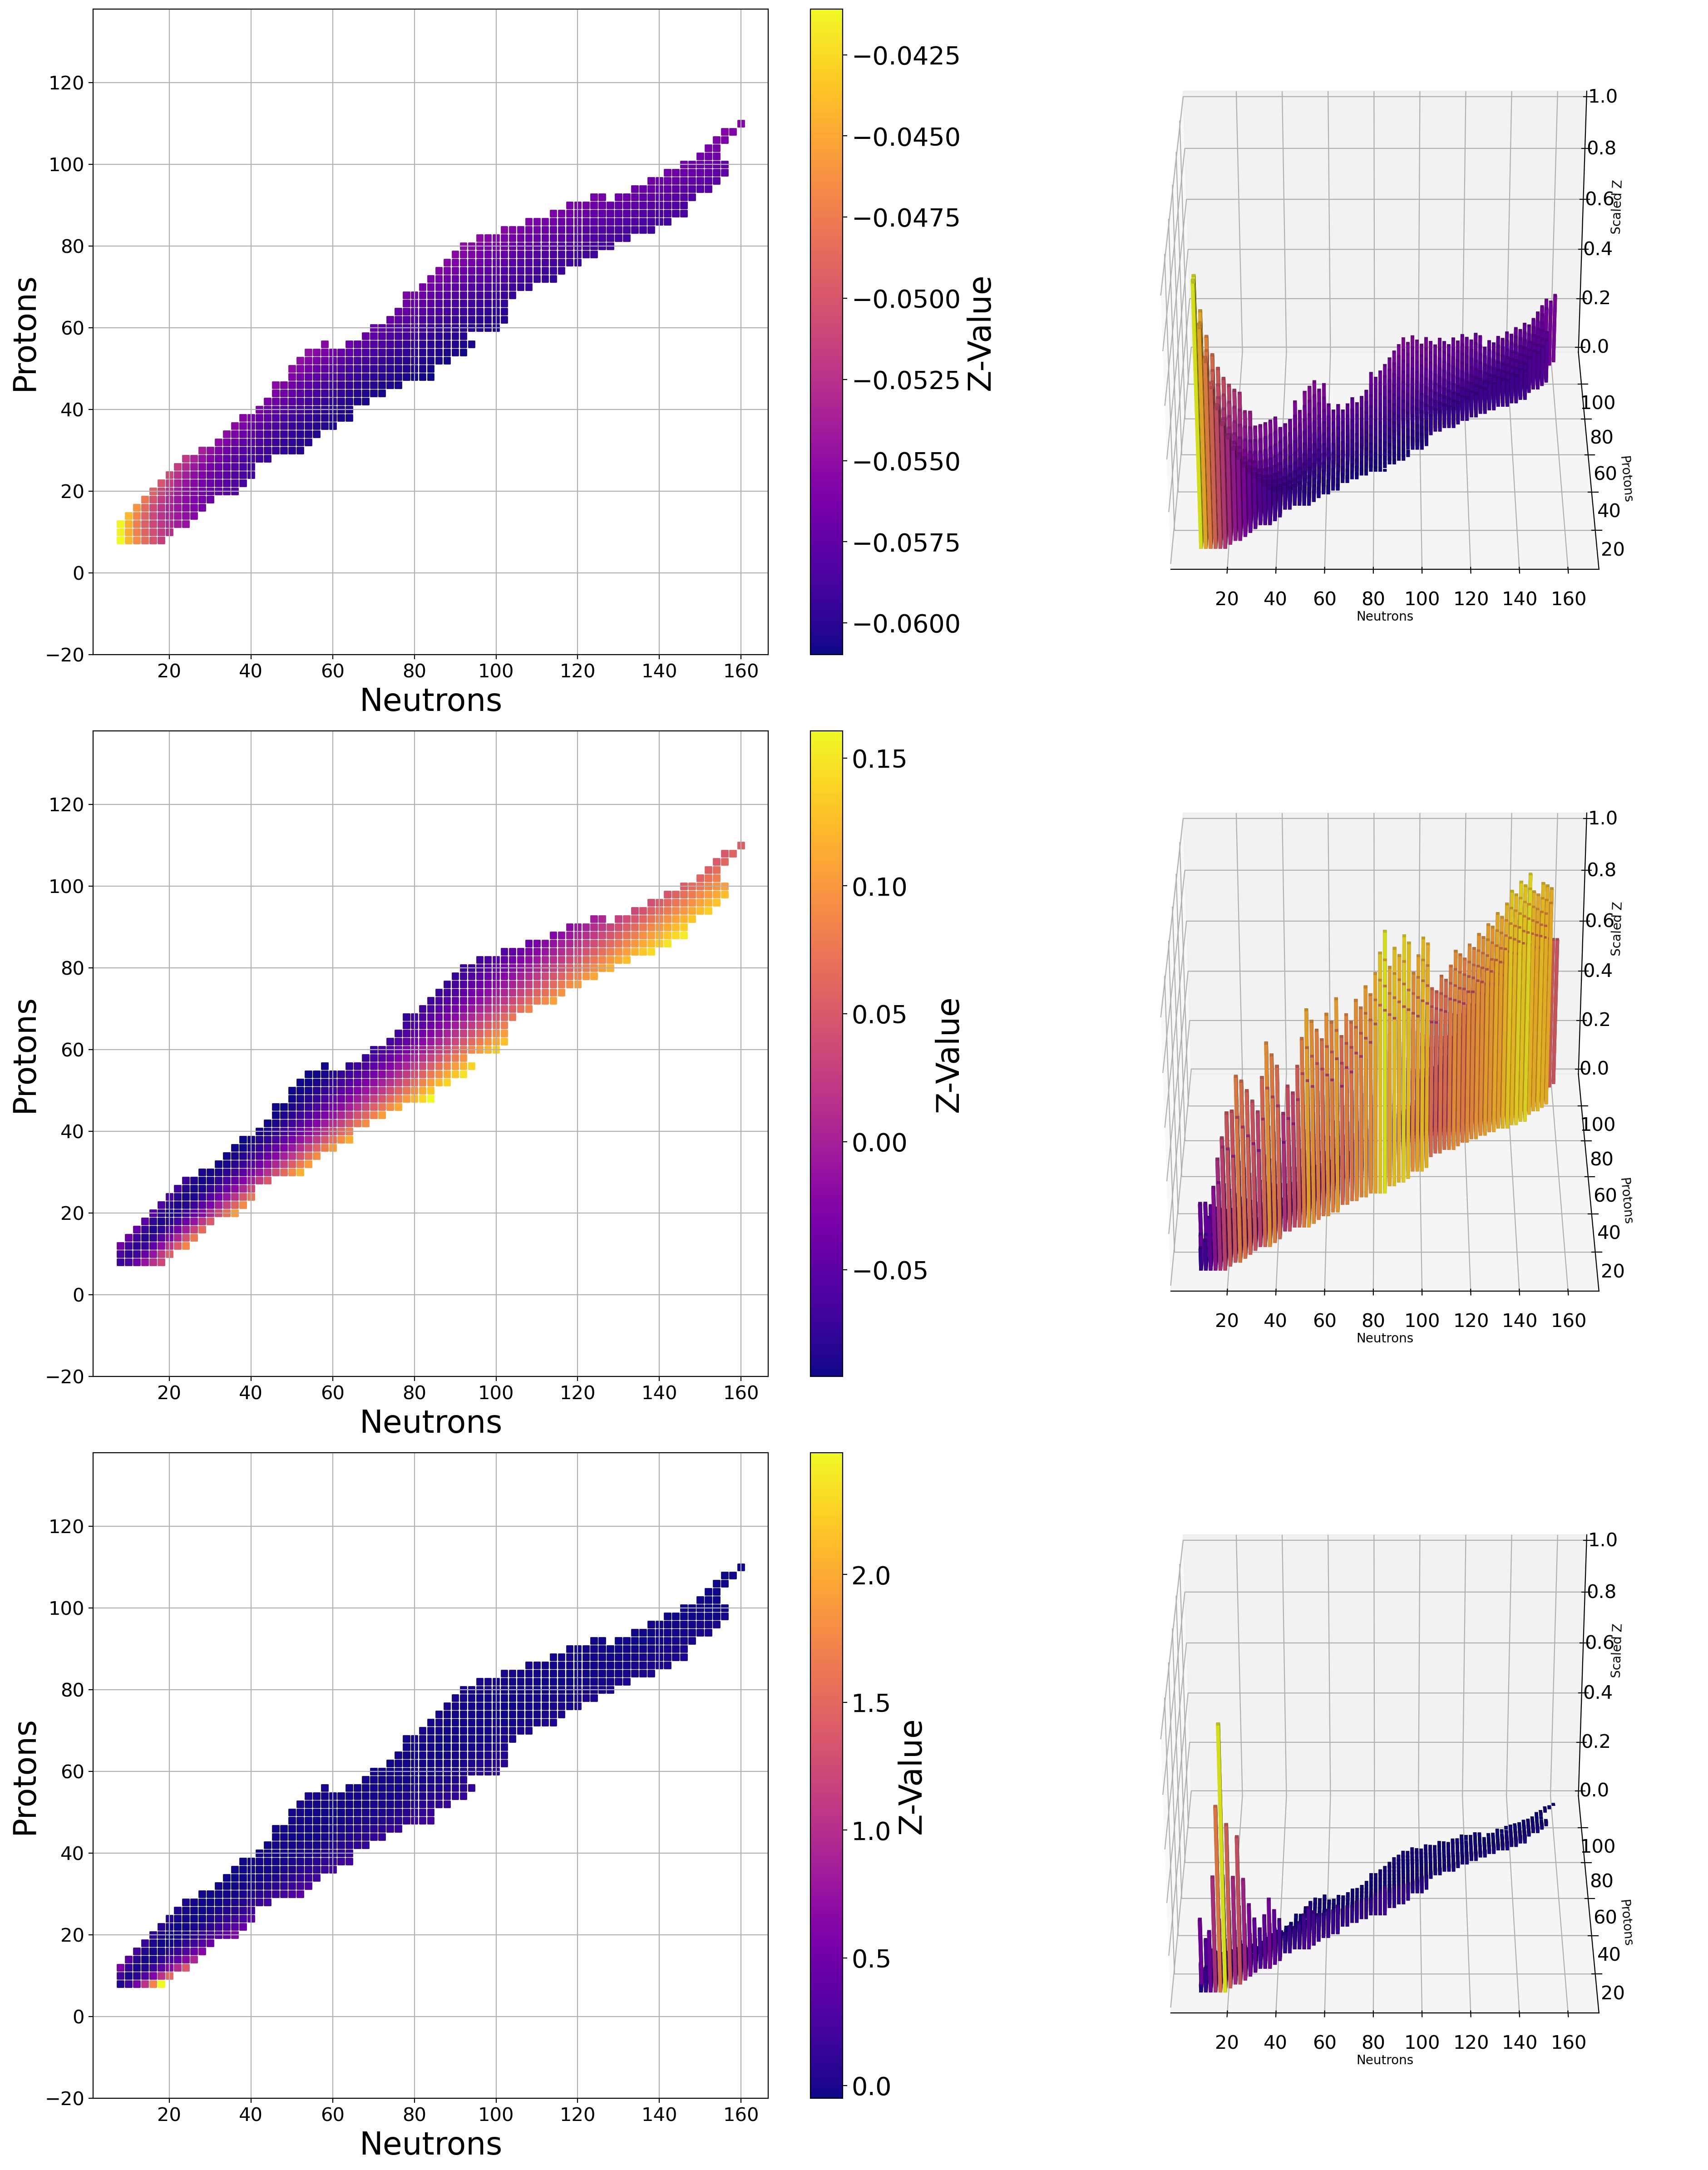

In [456]:
PlotMultiple(pc_data,[30,-90])

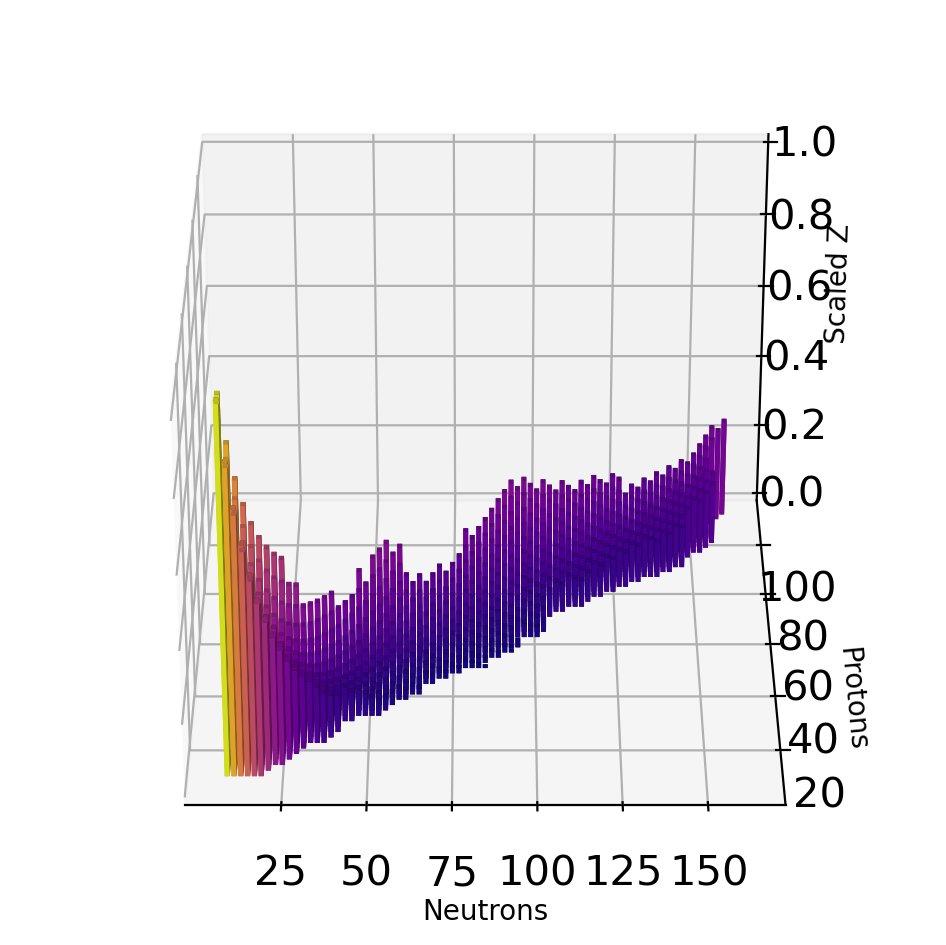

In [457]:
Plotter3D_single(pc_data[0],elev=30,azim=-90)

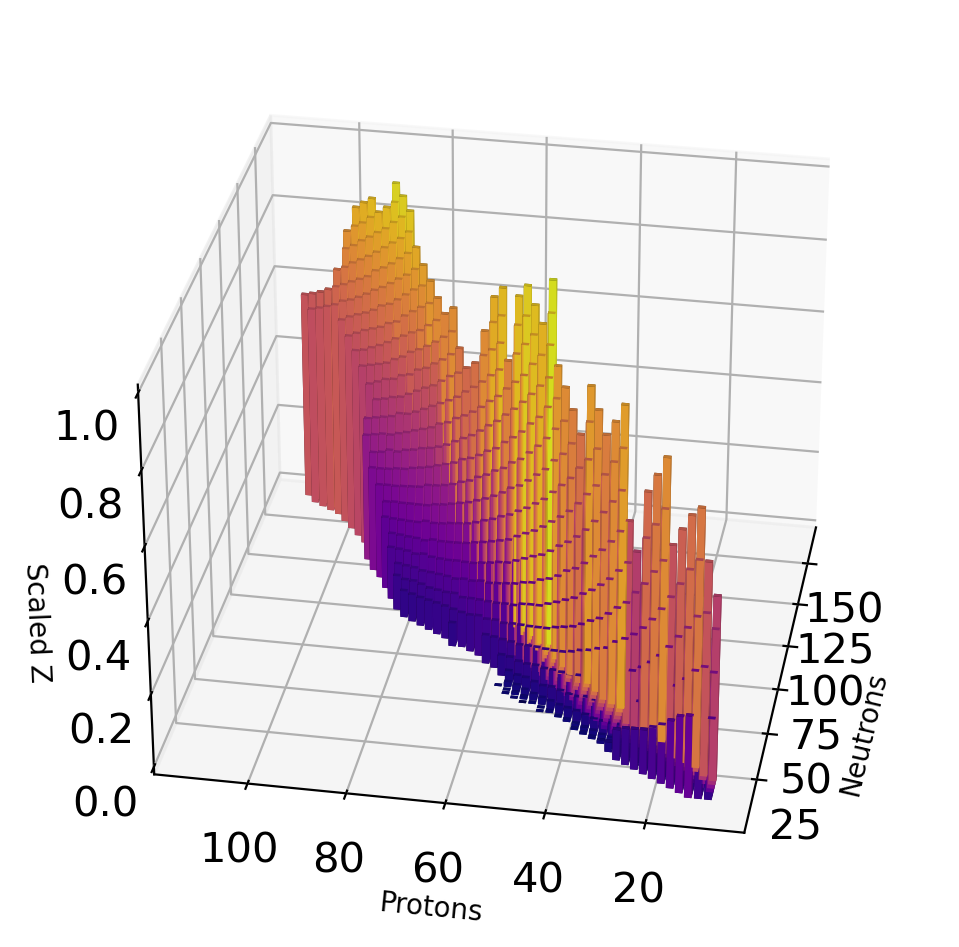

In [458]:
Plotter3D_single(pc_data[1],elev=30,azim=-170)

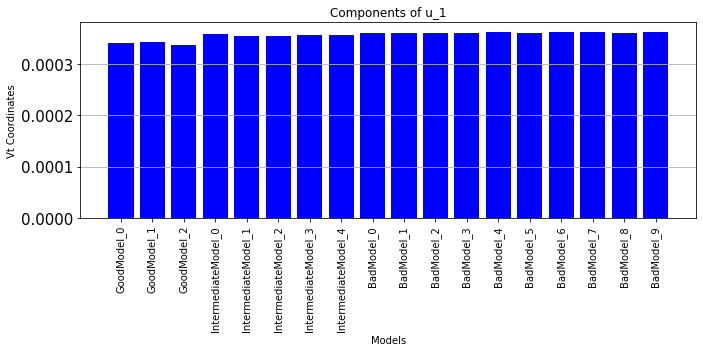

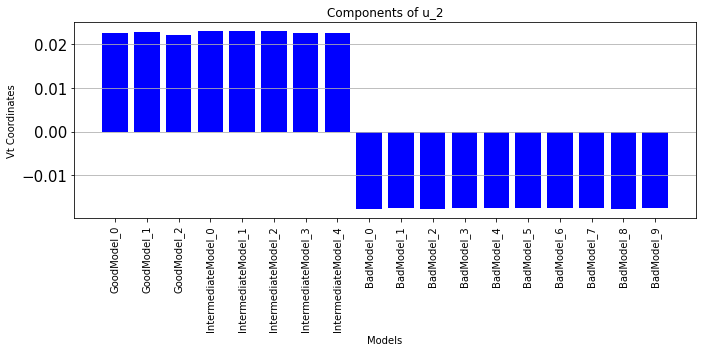

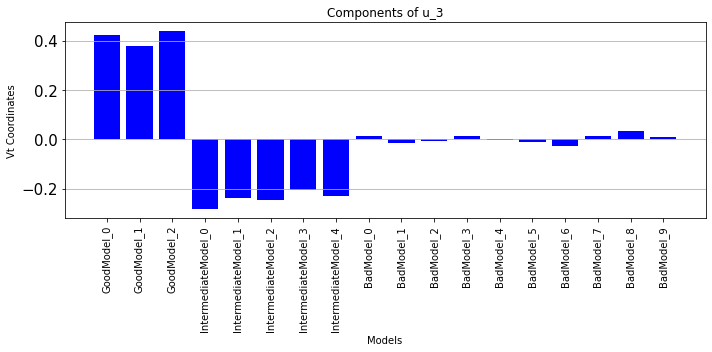

In [459]:


for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], key_list, title=f"Components of u_{i+1}", color='blue')

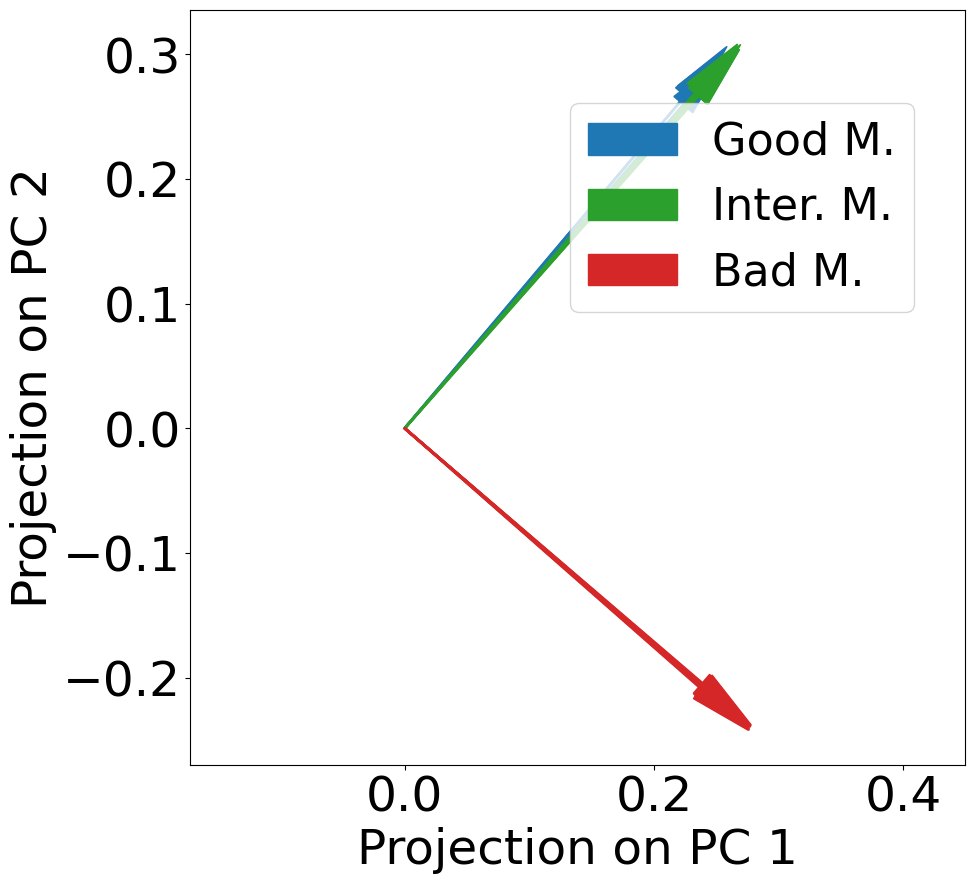

In [466]:

plt.rc("xtick", labelsize=35)
plt.rc("ytick", labelsize=35)

fig, ax = plt.subplots(figsize=(10,10), dpi=100)

model_index=0
class_index=0

visited_model=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1

            ax.arrow(0, 0, Vt_hat_normalized.T[visited_model][0],Vt_hat_normalized.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
           
        else:
            ax.arrow(0, 0, Vt_hat_normalized.T[visited_model][0], Vt_hat_normalized.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
        model_index=model_index+1
        visited_model=visited_model+1
    class_index=class_index+1
    legend_flag=0


# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-0.25, 0.9)

# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC 1',fontsize=35)
plt.ylabel('Projection on PC 2',fontsize=35)

plt.legend(loc=(0.49, 0.6),fontsize=32)
# ax.set_xticks([-0.2,0,0.2,0.4,0.6])
plt.axis('equal')
# plt.xlim(-0.25, 0.6)
# plt.ylim(-0.43, 0.5)

plt.show()


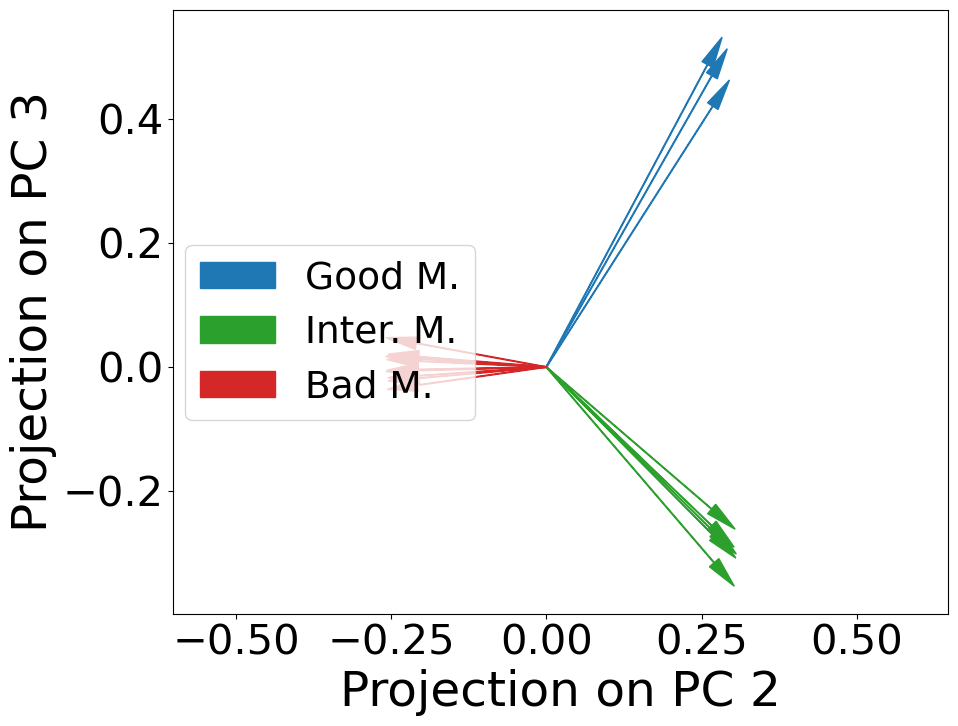

In [467]:

if components_kept>2:

    plt.rc("xtick", labelsize=30)
    plt.rc("ytick", labelsize=30)

    fig, ax = plt.subplots(figsize=(10,8), dpi=100)

    model_index=0
    class_index=0

    visited_model=0
    for n_vals in n_classes:
        legend_flag=0
        for i in range(n_vals):
            if legend_flag==0:
                legend_flag=1

                plt.arrow(0, 0, Vt_hat_normalized.T[visited_model][1], Vt_hat_normalized.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
            
            else:
                plt.arrow(0, 0, Vt_hat_normalized.T[visited_model][1], Vt_hat_normalized.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
            model_index=model_index+1
            visited_model=visited_model+1
        class_index=class_index+1
        legend_flag=0


    # Determine plot limits based on the maximum absolute values of the vectors
    # max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
    # plt.xlim(-max_val-1, max_val+1)
    # plt.ylim(-max_val-1, max_val+1)

    plt.xlabel('Projection on PC 2',fontsize=35)
    plt.ylabel('Projection on PC 3',fontsize=35)

    plt.legend(loc=(0.015, 0.32),fontsize=27)

    plt.axis('equal')

    plt.show()


In [468]:
X=np.copy(U_hat)
if centering_data:
    y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean
else:
    y=np.copy(models_output_train["truth"].tolist())

In [469]:
#Making the list of principal components across the train part. These should be identical to the X on top made by \hat U
X_train=[]
for i in range(num_components):
    X_train.append(models_PC_train[key_list_PCs[i]].tolist() )
# if centering_data==True:
#     for i in range(num_components):
#         X_train.append(models_PC_train[key_list_PCs[i]].tolist() )

# else:
#     for i in range(num_components):
#         X_train.append(models_PC_train[key_list_PCs[i]].tolist())

X_train=np.array(X_train)

In [470]:
#Making the list of principal components across the validation part
X_validation=[]
for i in range(num_components):
    X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
# if centering_data==True:
#     for i in range(num_components):
#         X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
X_validation=np.array(X_validation)

In [471]:
#Making the list of principal components across the testing part
X_test=[]
for i in range(num_components):
    X_test.append(models_PC_testing[key_list_PCs[i]].tolist())

# if centering_data==True:
#     for i in range(num_components):
#         X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
X_test=np.array(X_test)

In [472]:
#Making the list of principal components across the entire chart (training+validation+testing)
X_full=[]
for i in range(num_components):
    X_full.append(models_PC[key_list_PCs[i]].tolist())
# if centering_data==True:
#     for i in range(num_components):
#         X_full.append(models_PC[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_full.append(models_PC[key_list_PCs[i]].tolist())
X_full=np.array(X_full)

## For unconstrained estimation the problem is trivial and can be solved by linear equations:

In [473]:
# 1) Find the least square solution for the training part
X_T_X=X.dot(X.T)
X_T_X_inv = np.linalg.inv(X_T_X)

beta = X_T_X_inv.dot(X).dot(y)

# if centering_data==True:
#     supermodel=X.T.dot(beta) + predictions_train_mean
# else:
#     supermodel=X.T.dot(beta)

#1.5) Construct the super model across the entire range and the test range
if centering_data:
    beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
else:
    beta_full=np.copy(beta)



supermodel=X_train.T.dot(beta_full)

supermodel_train=X_train.T.dot(beta_full)
# supermodel_train=np.copy(supermodel)

supermodel_validation=X_validation.T.dot(beta_full)
supermodel_test=X_test.T.dot(beta_full)
supermodel_full=X_full.T.dot(beta_full)


# 2) Construct the covariance matrix
if centering_data==True:
    residuals = y - supermodel + predictions_train_mean
else:
    residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=500000)


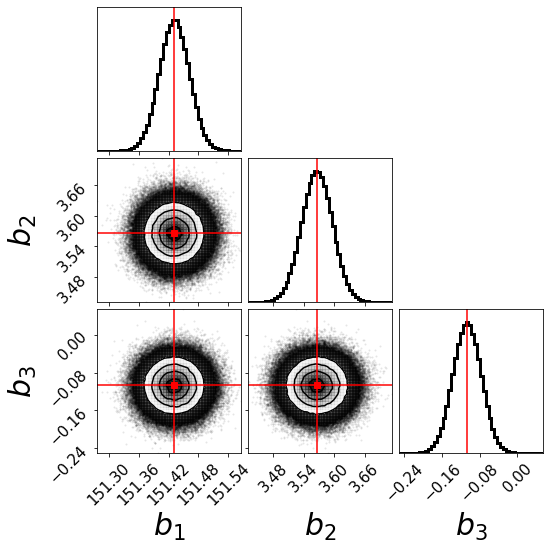

In [474]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(samples,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

## For constrained estimation the problem is more complex and we need to define our likelihood and prior functions (we are putting the constraint in the prior)

In [489]:
if centering_data:  #Calculating a bias term to add to the coefficient transformation to account for the \phi0 term
    bias0=np.full(len(len(model_predictions_train.T)),1/len(len(model_predictions_train.T)))
else:
    bias0=np.full(len(model_predictions_train.T),0)

In [491]:
def b1_finder(beta_2m,Vt_hat):
#     beta_2m is a list of the beta values that are active
    if len(beta_2m)<1:
        print("AAAAAAAAAAA!")
    return (1-np.sum(bias0)-np.sum(np.dot(Vt_hat[1:].T,beta_2m)))/np.sum(Vt_hat[0].T)

In [492]:
# Define the likelihood function for given errors sigma
def log_likelihood_PC(beta_2m,data):
    #Assumed format for data=[yvals], it is also assummed to be centered or not centered directly (either y-\phi0 or just y)
    
    beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
    
    residuals=y-X_train.T.dot(beta)

    return -np.sum(residuals**2)




In [493]:
# Define the likelihood function for given errors sigma
def log_likelihood_PC_unormalized(beta,data):
    #Assumed format for data=[yvals], it is also assummed to be centered or not centered directly (either y-\phi0 or just y)
    
#     beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
    
    residuals=y-X_train.T.dot(beta)

    return -np.sum(residuals**2)




In [494]:
# Define the prior function
def log_prior_PC(beta_2m,Vt_hat):
    beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
    
    omegas=np.dot(beta,Vt_hat) + bias0
    
    
    if  np.any(omegas < 0):
        return -np.infty
    else:
        return 0
    

In [495]:
# Define the prior function
def log_prior_PC_unormalized(beta,Vt_hat):
#     beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
    
    omegas=np.dot(beta,Vt_hat) + bias0
    
    return 0
    
    if  np.any(omegas < 0):
        return -np.infty
    else:
        return 0
    

In [526]:
# Define the Metropolis algorithm
def metropolis(data,sigma, log_prior,log_likelihood,\
               num_iterations, step_size,initial_parameters,Vt_hat,normalized=True):
#     step_size should be a list the size of the parameters of the model


    #thermalizing
    burn_samples=20000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    

    
    log_posterior_current=(log_likelihood(params_current,data))/sigma**2 + (log_prior(params_current,Vt_hat))

    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)

        log_posterior_proposed=(log_likelihood(params_proposed,data))/sigma**2 + (log_prior(params_proposed,Vt_hat))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
   
        log_posterior_proposed=(log_likelihood(params_proposed,data))/sigma**2+ (log_prior(params_proposed,Vt_hat))
#         print(log_posterior_proposed)
        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        if normalized:
            params_list.append(np.insert(params_current, 0, b1_finder(params_current,Vt_hat)))
        else:
            params_list.append(params_current)
        posterior_list.append(log_posterior_current*sigma**2)
        
    
    #Rule of thumb acceptance is around 30%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)

In [ ]:
# %%time
# #For the case of 1, 1, 1 models keeping 3 PC
# met_res=metropolis(y,0.05, log_prior_PC,log_likelihood_PC,\
#                100000, np.array([0.004,0.004]),np.array([0.0,0.0]),Vt_hat,normalized=True)

In [513]:
%%time
#For the case of 3, 5, 10 models keeping 3 PC
met_res=metropolis(y,0.05, log_prior_PC,log_likelihood_PC,\
               100000, np.array([0.002,0.002]),np.array([0.0,0.0]),Vt_hat,normalized=True)

22.534000000000002 %
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.4 s


In [518]:
emp_sigma=np.sqrt(-np.mean(met_res[1])/len(y))

In [519]:
emp_sigma

0.061257485858562506

In [527]:
%%time
met_res=metropolis(y,emp_sigma, log_prior_PC,log_likelihood_PC,\
               300000, np.array([0.002,0.002]),np.array([0.0,0.0]),Vt_hat,normalized=True)

32.15266666666667 %
CPU times: user 31.4 s, sys: 0 ns, total: 31.4 s
Wall time: 31.4 s


In [521]:
np.sqrt(-np.mean(met_res[1])/len(y))/emp_sigma

1.0007436639820786

In [528]:
emp_sigma=np.sqrt(-np.mean(met_res[1])/len(y))

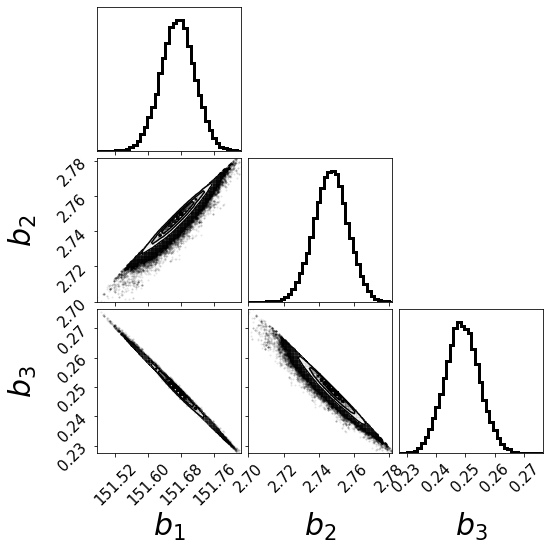

In [529]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(met_res[0],bins=40, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)],
#                        truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

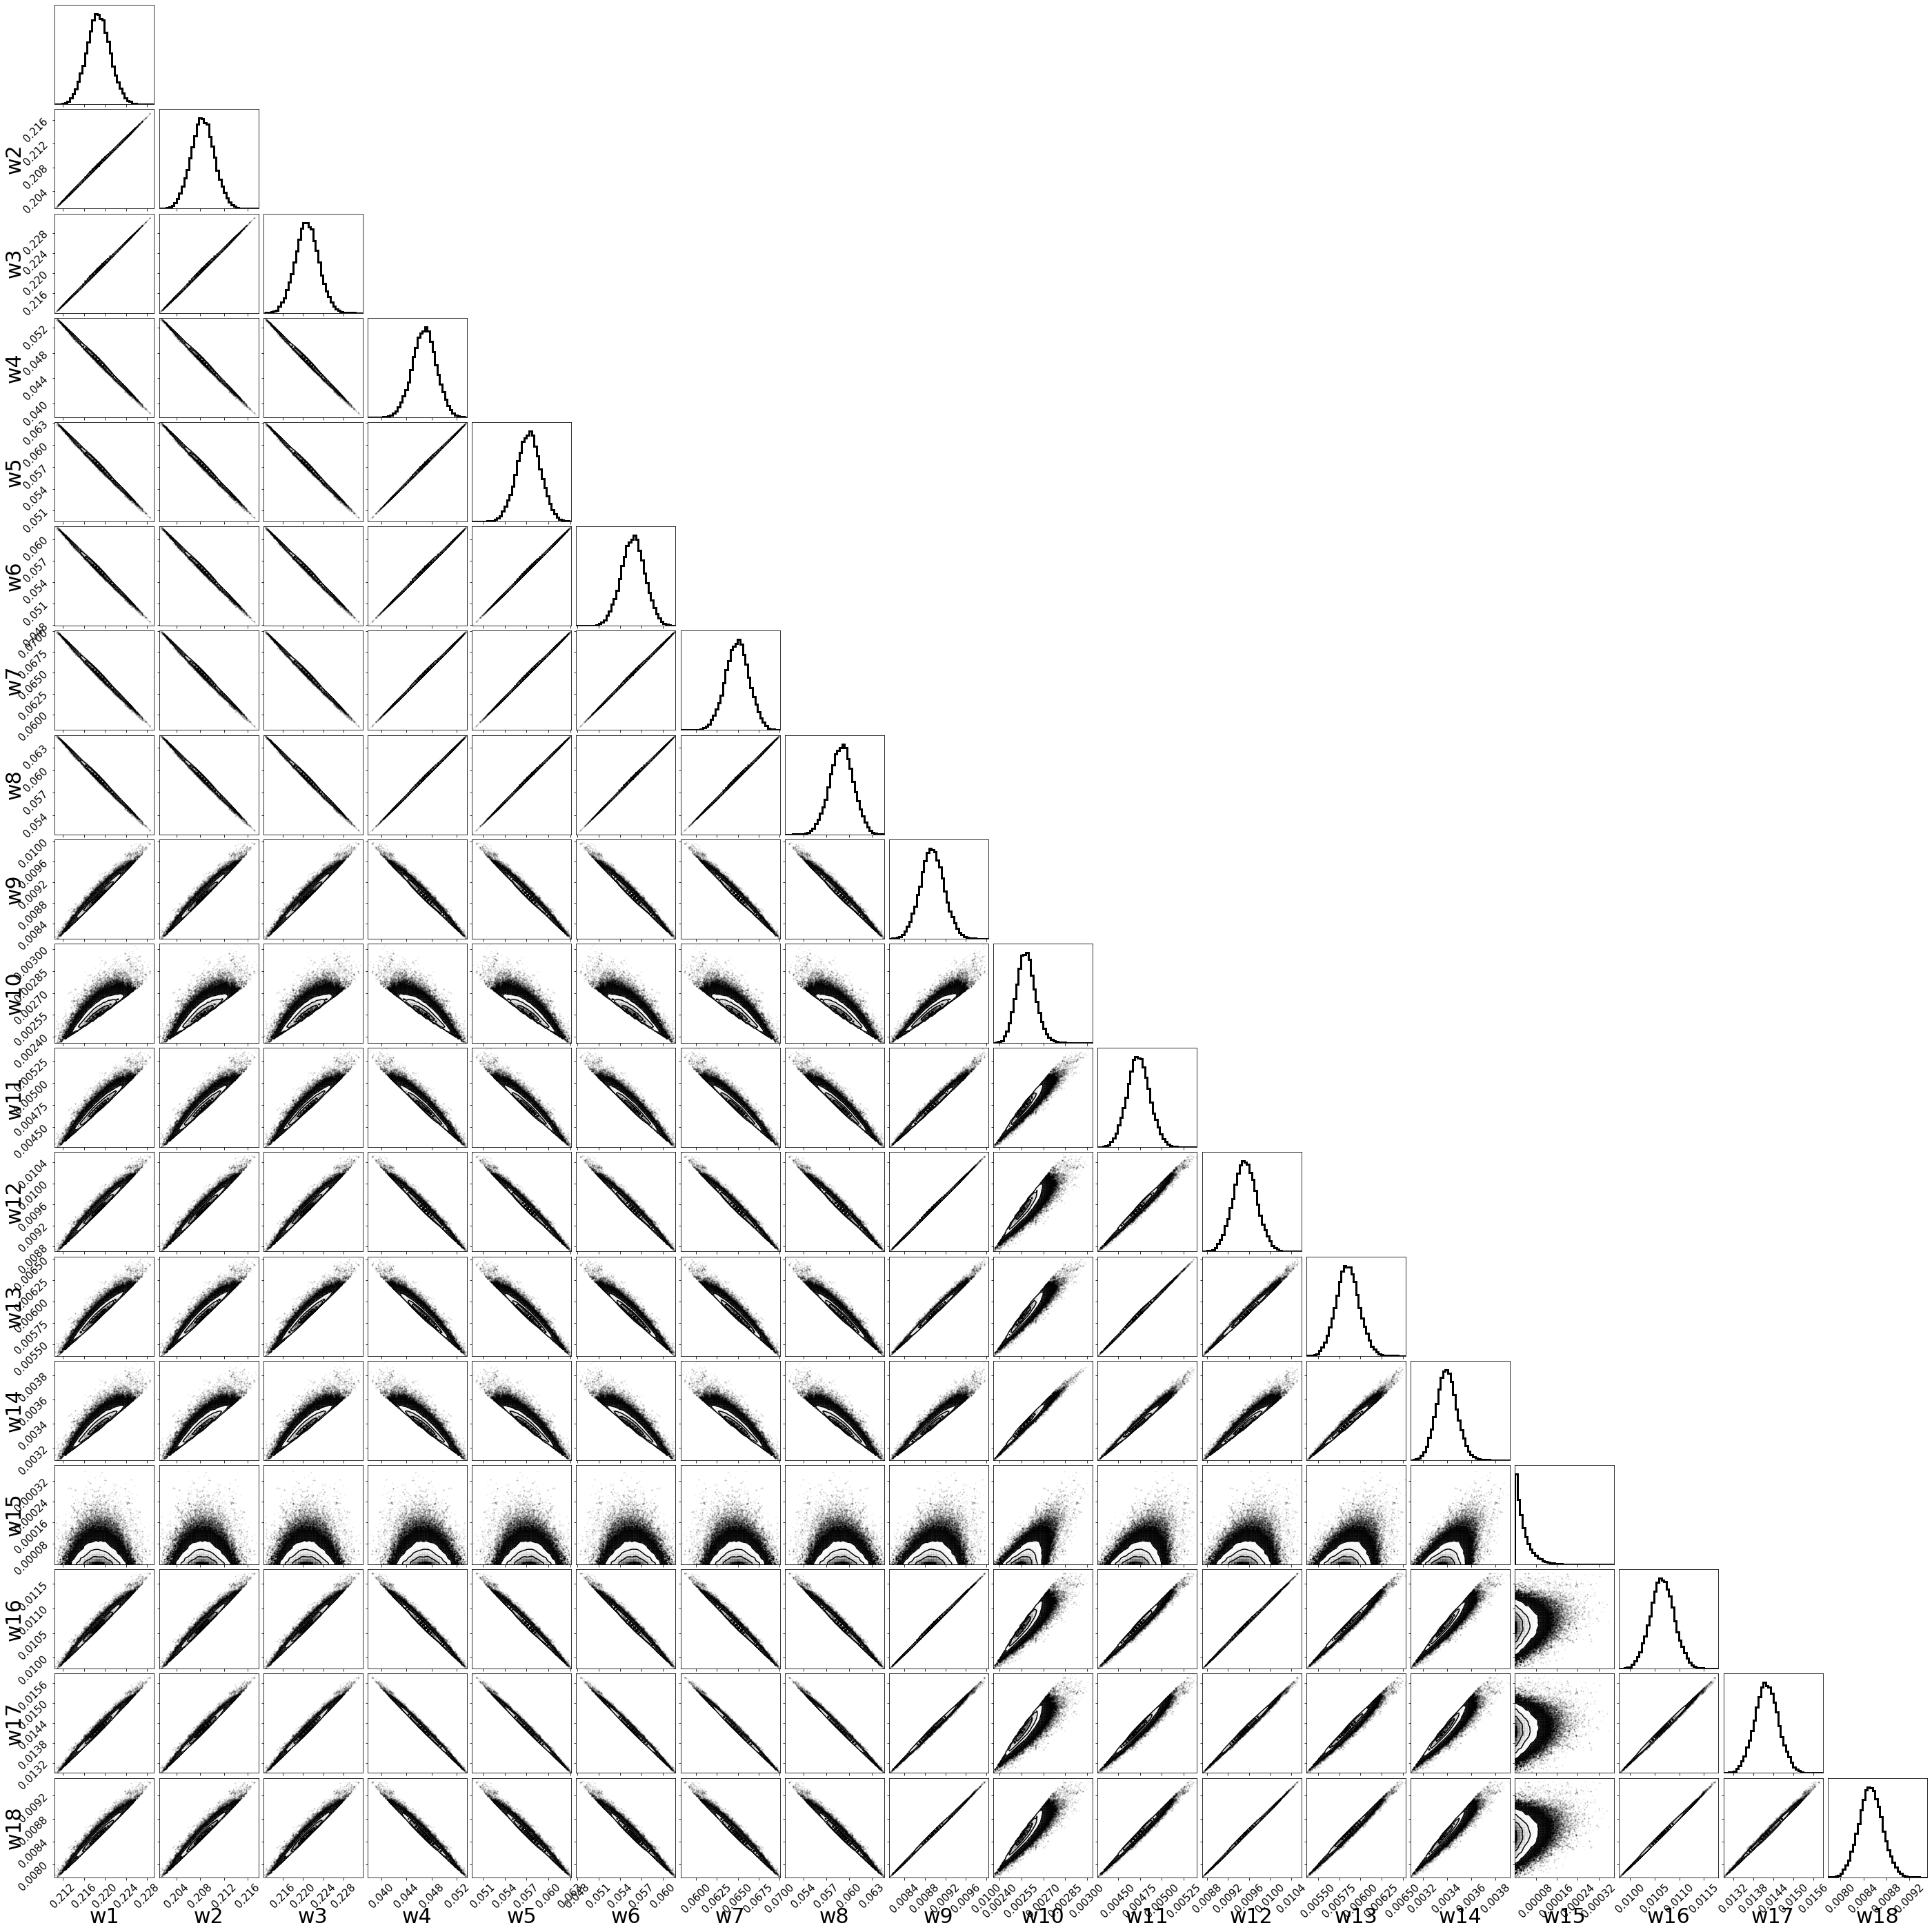

In [530]:
# # 4) Make a corner plot in the space of the naive models
samples_naive_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in met_res[0]])


figure = corner.corner(samples_naive_space, bins=40, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 30})
# figure = corner.corner(samples_naive_space)

plt.show()

In [531]:
[np.sum(samples_naive_space[i]) for i in range(len(samples_naive_space))]

[1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 0.9999999999999999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 0.9999999999999

In [314]:
met_res_unnorm=metropolis(y,0.5, log_prior_PC_unormalized,log_likelihood_PC_unormalized,\
               50000, np.array([1,0.1,0.1]),np.array([150,0.0,0.0]),Vt_hat,normalized=False)

37.291999999999994 %


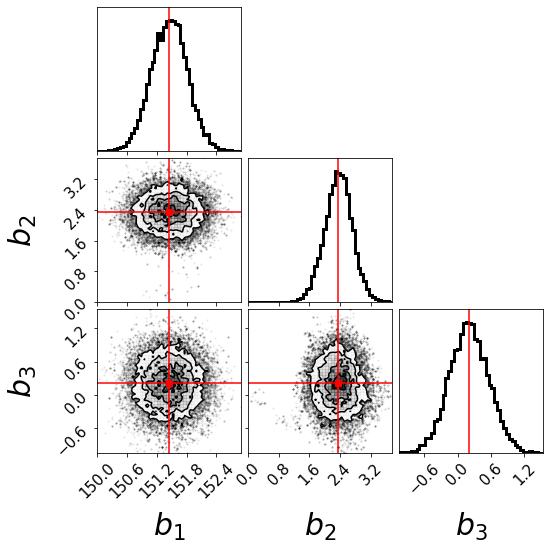

In [315]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(met_res_unnorm[0],bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

In [639]:
# # # 4) Make a corner plot in the space of the naive models
# samples_naive_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


# figure = corner.corner(samples_naive_space, bins=50, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 30})
# # figure = corner.corner(samples_naive_space)

# plt.show()


In [505]:
# if centering_data:  #If we centered the data, to recover the correct weights we need to take into account the existence of P0

#     # # 4) Make a corner plot in the space of the naive models
#     samples_naive_space = np.array([np.dot(betaval,Vt_hat) + np.full(len(Vt_hat.T),1/len(Vt_hat.T)) for  betaval in samples])


#     figure = corner.corner(samples_naive_space, bins=50, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat)+ np.full(len(Vt_hat.T),1/len(Vt_hat.T)),label_kwargs={"fontsize": 20})
#     # figure = corner.corner(samples_naive_space)

#     plt.show()


### Following the same procedure but using the full space of models (without PCA)

In [59]:
X_naive=np.copy(model_predictions_train).T
X_full_naive=np.copy(model_predictions).T
X_test_naive=np.copy(model_predictions_test).T
X_validation_naive=np.copy(model_predictions_validation).T

y_naive=np.copy(models_output_train["truth"].tolist())
y_naive_test=np.copy(models_output_test["truth"].tolist())
y_naive_validation=np.copy(models_output_validation["truth"].tolist())
y_naive_full=np.copy(models_output["truth"].tolist())



In [60]:
#Same process on the naive space of full models    

# 1) Find the least square solution for the training part
X_T_X_naive=X_naive.dot(X_naive.T)
X_T_X_inv_naive = np.linalg.inv(X_T_X_naive)
beta_naive = X_T_X_inv_naive.dot(X_naive).dot(y_naive)
supermodel_naive=X_naive.T.dot(beta_naive)

#1.5) Construct the super model across the entire range and the test range
supermodel_train_naive=np.copy(supermodel_naive)
supermodel_full_naive=X_full_naive.T.dot(beta_naive)
supermodel_test_naive=X_test_naive.T.dot(beta_naive)
supermodel_validation_naive=X_validation_naive.T.dot(beta_naive)


# 2) Construct the covariance matrix
residuals_naive = y_naive - supermodel_naive
sigma_squared_naive = np.sum(residuals_naive**2) / len(residuals_naive) 
# cov_matrix_naive = sigma_squared_naive * X_T_X_inv_naive
cov_matrix_naive = sigma_squared_naive * X_T_X_inv_naive

# 3) Make a corner plot
samples_naive = np.random.multivariate_normal(beta_naive, cov_matrix_naive, size=50000)


In [508]:
# figure = corner.corner(samples_naive, bins=50, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'$w_{i}$' for i in range(1,1+len(beta_naive))], truths=beta_naive,label_kwargs={"fontsize": 30})
# # figure = corner.corner(samples_naive_space)

# plt.show()

In [61]:
beta_naive

array([ 0.29104221,  0.77177741, -0.08223886])

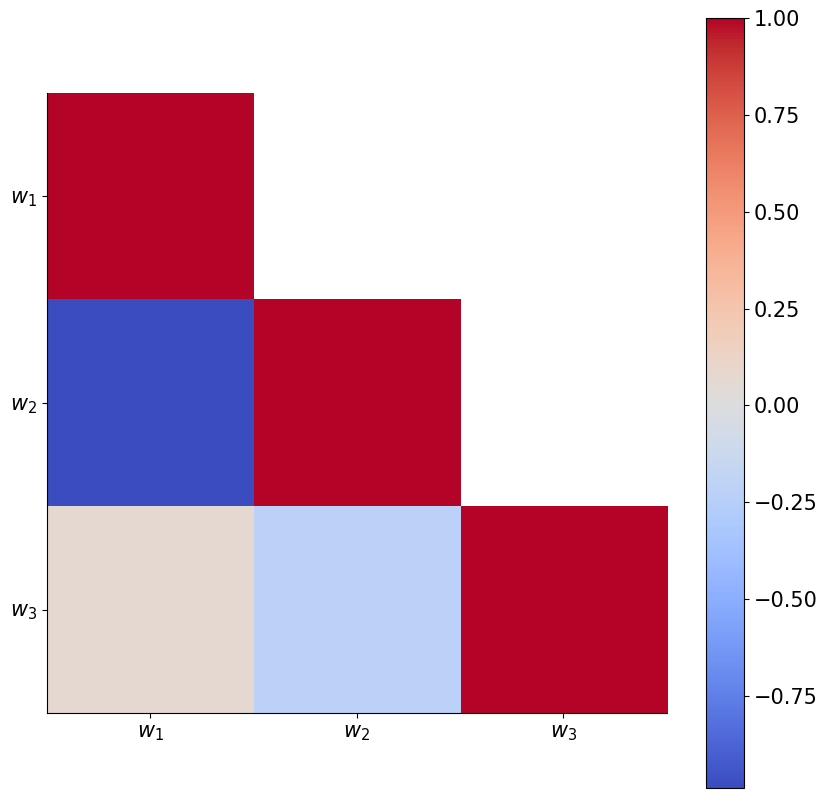

In [510]:
correlation_matrix_naive = cov_matrix_naive / np.sqrt(np.outer(np.diag(cov_matrix_naive), np.diag(cov_matrix_naive)))

mask = np.triu_indices_from(correlation_matrix_naive, k=1)
correlation_matrix_naive[mask] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap

# cax = ax.matshow(correlation_matrix_naive, cmap='coolwarm', vmin=0.99925, vmax=1)
cax = ax.matshow(correlation_matrix_naive, cmap='coolwarm')
# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(correlation_matrix_naive)))
ax.set_yticks(np.arange(len(correlation_matrix_naive)))

plot_labels=[f"$w_{{{i}}}$" for i in range(1, len(correlation_matrix_naive) + 1)]
ax.set_xticklabels(plot_labels)
ax.set_yticklabels(plot_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_bottom()

# Show the plot
plt.show()

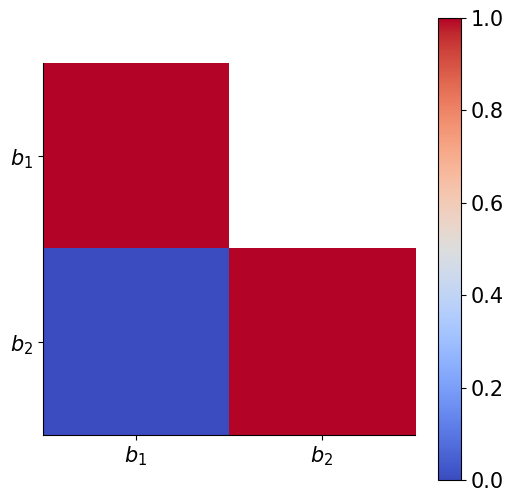

In [424]:
correlation_matrix = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))

mask = np.triu_indices_from(correlation_matrix, k=1)
correlation_matrix[mask] = np.nan

fig, ax = plt.subplots(figsize=(6, 6))

# Create the heatmap

# cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(correlation_matrix)))
ax.set_yticks(np.arange(len(correlation_matrix)))

plot_labels=[f"$b_{i}$" for i in range(1, len(correlation_matrix) + 1)]

ax.set_xticklabels(plot_labels)
ax.set_yticklabels(plot_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_bottom()

# Show the plot
plt.show()

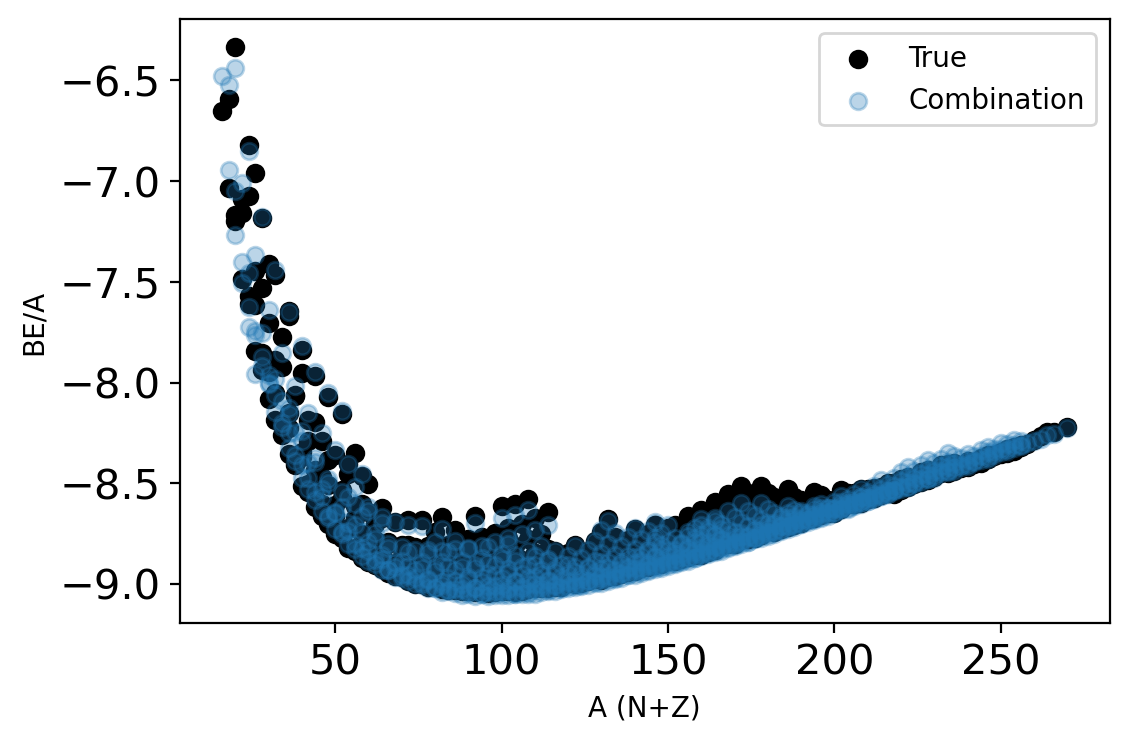

In [532]:
fig = plt.subplots(dpi=200)

plt.scatter(x = models_output["A"], y = models_output['truth'], label = str("True"), color='k')




plt.scatter(x = models_output["A"], y = supermodel_full, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [335]:
#Restricting the super model to plot on the selected isotope 
X_full_filtered=[]

for i in range(len(X_full)):
    X_full_filtered.append(X_full[i][filtered_models_output.index])
X_full_filtered=np.array(X_full_filtered)

In [533]:
rng = np.random.default_rng()
# theta_rand = rng.choice(samples, (50000), replace=False)
appropiate_sigma=sigma_squared

theta_rand = rng.choice(met_res[0], (50000), replace=False)
appropiate_sigma=emp_sigma**2

rndm_m = []

for i in range(len(theta_rand)):
    if centering_data:
        yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand[i], 0, 1))
    else:
        yvals_rand= X_full_filtered.T.dot(theta_rand[i])

    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(yvals_rand)
                       ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * appropiate_sigma ) )))   

In [372]:
#Restricting the full naive model to the isotopes we want
model_predictions_filtered=[]

for i in range(len(model_predictions.T)):
    model_predictions_filtered.append(model_predictions.T[i][filtered_models_output.index])
model_predictions_filtered=np.array(model_predictions_filtered)

In [374]:
rndm_m_naive=[]

for i in range(len(samples_naive)):

    yvals_rand= model_predictions_filtered.T.dot(samples_naive[i])

    rndm_m_naive.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(yvals_rand)
                       ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * sigma_squared_naive ) )))   

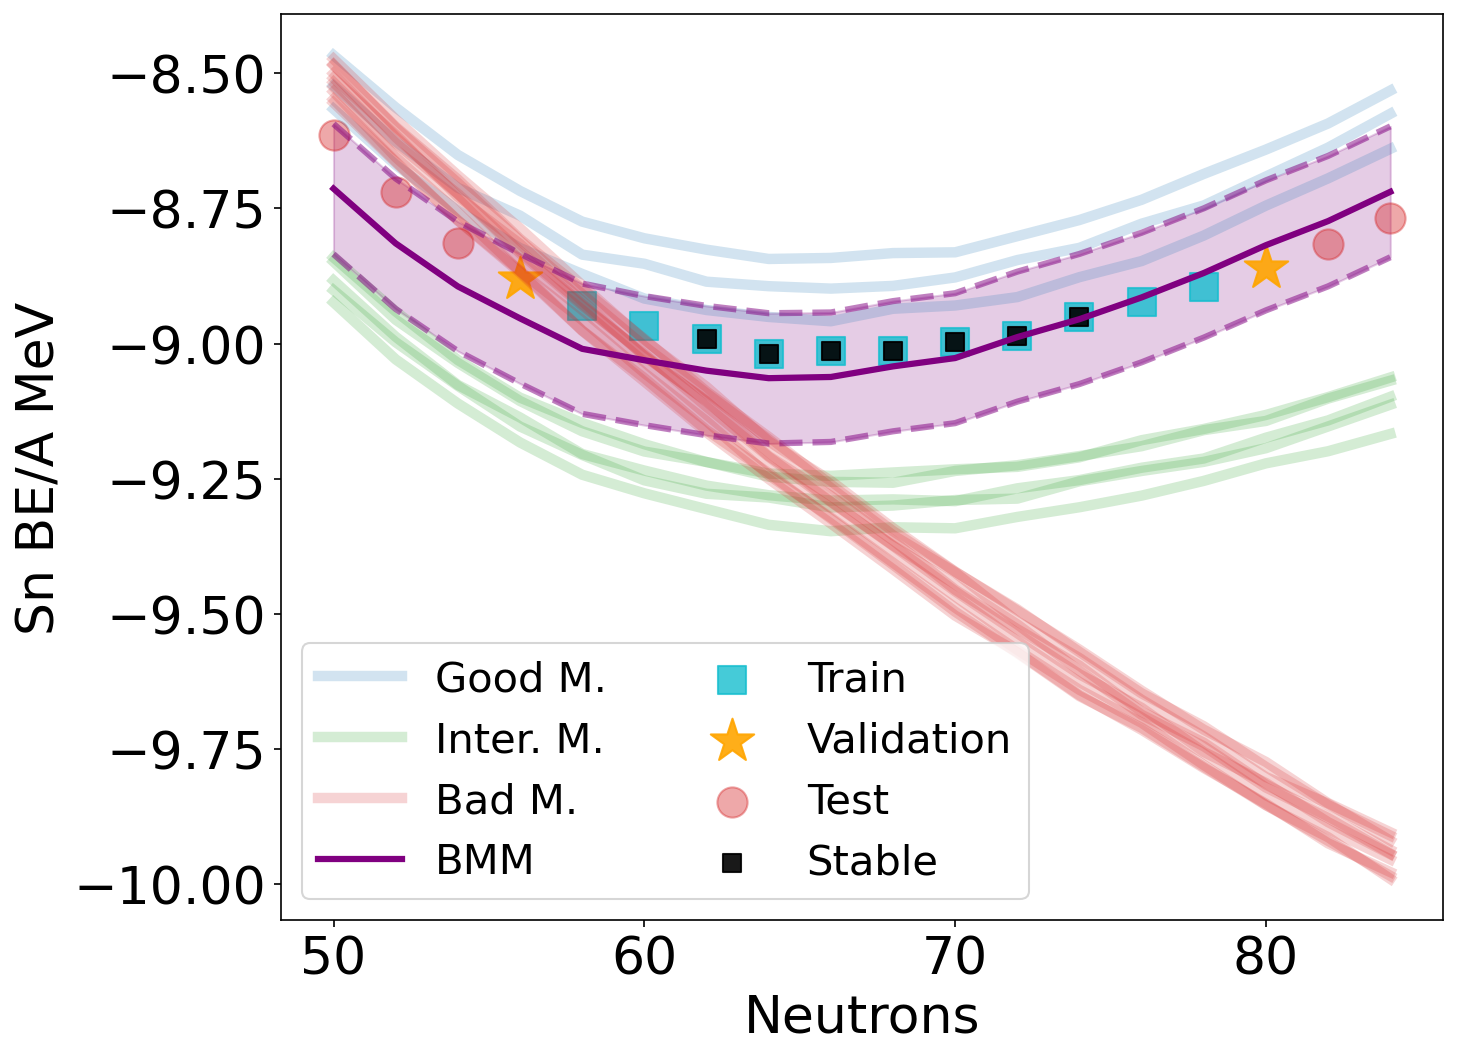

In [534]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(10,8), dpi=150)
# fig, ax = plt.subplots(dpi=200)

alpha_models=0.2

model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = alpha_models,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0



#Select what to plot, either the super model or the naive version


name="BMM-PC"
samples_plot=np.copy(rndm_m)



# name="BMM-0"
# samples_plot=np.copy(rndm_m_naive)



mean = np.mean(samples_plot,axis=0)
upper = (np.percentile(samples_plot, 97.5, axis=0))

lower = (np.percentile(samples_plot, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='BMM',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2)




# ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth (Train)",color='k',s=200)

# ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'],
#             label = "Truth (Test)",color='orange',s=400,marker="*",edgecolor='face', linewidth=1.5,alpha=1)


# ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'],
#             label = "Truth (Test)",color='orange',s=400,marker="*",edgecolor='face', linewidth=1.5,alpha=1)


size_multiplyier=6

ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Train",  alpha = alpha_trainig,color=color_trainig,s=size_trainig*size_multiplyier,marker=marker_trainig)

ax.scatter(x = filtered_models_output_validation["N"], y = filtered_models_output_validation['truth'], label = "Validation", alpha=alpha_validation ,color=color_validation,s=size_validation*size_multiplyier,marker=marker_validation)

ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'], label = "Test", alpha = alpha_testing,color=color_testing,s=size_testing*size_multiplyier,marker=marker_testing)

ax.scatter(x = filtered_models_output_stable["N"], y = filtered_models_output_stable['truth'], label = "Stable", alpha = 0.9,color='k',s=80,marker="s")





plt.xlabel("Neutrons",fontsize=25)
plt.ylabel(Selected_element_name+ " BE/A MeV",fontsize=25)
plt.legend(fontsize=20,markerscale=1,ncol=2 )

plt.show()

In [376]:
super_model_resituals_train=supermodel_train  -  models_output_train['truth'].tolist()
super_model_residuals_validation= supermodel_validation-models_output_validation['truth'].tolist()
super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()



naive_model_resituals_train=supermodel_train_naive-models_output_train['truth'].tolist()
naive_model_residuals_validation= supermodel_validation_naive-models_output_validation['truth'].tolist()
naive_model_residuals_test = supermodel_test_naive-models_output_test['truth'].tolist()





In [377]:
sigma_train=np.sqrt(np.sum(super_model_resituals_train**2) / len(super_model_resituals_train) )
sigma_validation=np.sqrt(np.sum(super_model_residuals_validation**2) / len(super_model_residuals_validation) )
sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )


sigma_naive_train=np.sqrt(np.sum(naive_model_resituals_train**2) / len(naive_model_resituals_train) )
sigma_naive_validation=np.sqrt(np.sum(naive_model_residuals_validation**2) / len(naive_model_residuals_validation) )
sigma_naive_test=np.sqrt(np.sum(naive_model_residuals_test**2) / len(naive_model_residuals_test) )



In [378]:
[sigma_train,sigma_validation,sigma_test]

[0.021981239595703243, 0.027315101464476597, 0.030223403682441117]

In [74]:
[sigma_naive_train,sigma_naive_validation,sigma_naive_test]

[0.018775910426785176, 0.03113299518350352, 0.045970521419004706]

In [75]:
model_summary

{'rmse_all': array([0.14871625, 0.10145449, 0.19722845, 0.35759095, 0.27295053,
        0.26834887, 0.31142221, 0.3186881 , 0.61133081, 0.58278209,
        0.60866348, 0.60491996, 0.6395405 , 0.59432596, 0.63431753,
        0.64298726, 0.58795561, 0.62144331]),
 'rmse_train': array([0.14372172, 0.09379726, 0.19613915, 0.31570488, 0.228735  ,
        0.22358085, 0.26933735, 0.27622013, 0.53375   , 0.50608775,
        0.53070528, 0.52812714, 0.56080141, 0.51679518, 0.55570112,
        0.56571002, 0.51229721, 0.54387816]),
 'rmse_validation': array([0.17197863, 0.12410186, 0.22238358, 0.35417557, 0.26904985,
        0.2641718 , 0.30608049, 0.31329082, 0.58098693, 0.55385093,
        0.57813816, 0.57403925, 0.60744693, 0.56433255, 0.60292045,
        0.6103899 , 0.55731583, 0.58966641]),
 'rmse_test': array([0.14757681, 0.10300372, 0.19133212, 0.39965961, 0.31561359,
        0.31140533, 0.35341851, 0.36114248, 0.69393579, 0.66385016,
        0.69158569, 0.68686785, 0.72396473, 0.67652998, 

In [76]:
list(models_output.keys())

['GoodModel_0',
 'GoodModel_1',
 'GoodModel_2',
 'IntermediateModel_0',
 'IntermediateModel_1',
 'IntermediateModel_2',
 'IntermediateModel_3',
 'IntermediateModel_4',
 'BadModel_0',
 'BadModel_1',
 'BadModel_2',
 'BadModel_3',
 'BadModel_4',
 'BadModel_5',
 'BadModel_6',
 'BadModel_7',
 'BadModel_8',
 'BadModel_9',
 'truth',
 'N',
 'Z',
 'A']

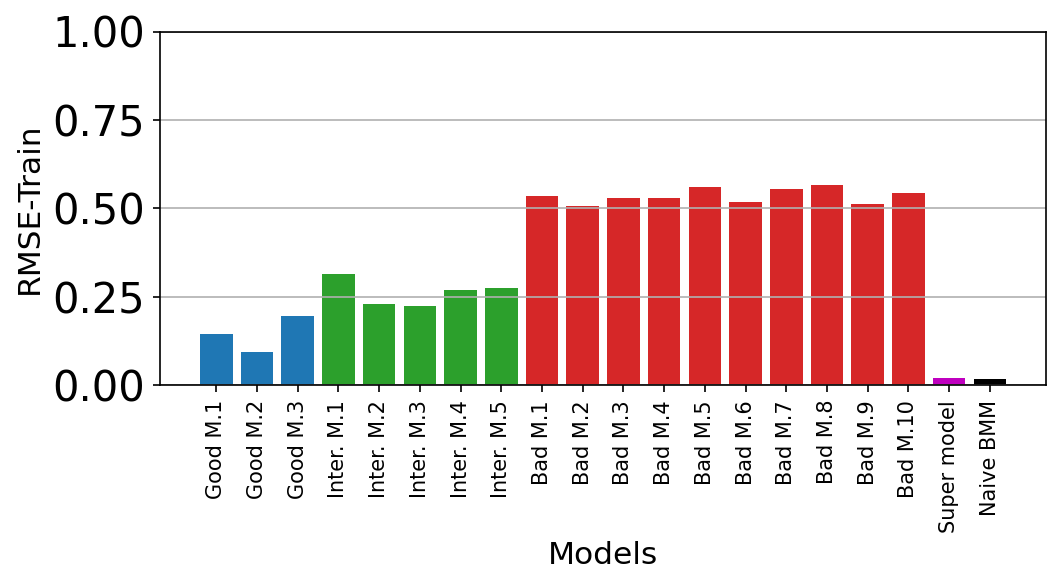

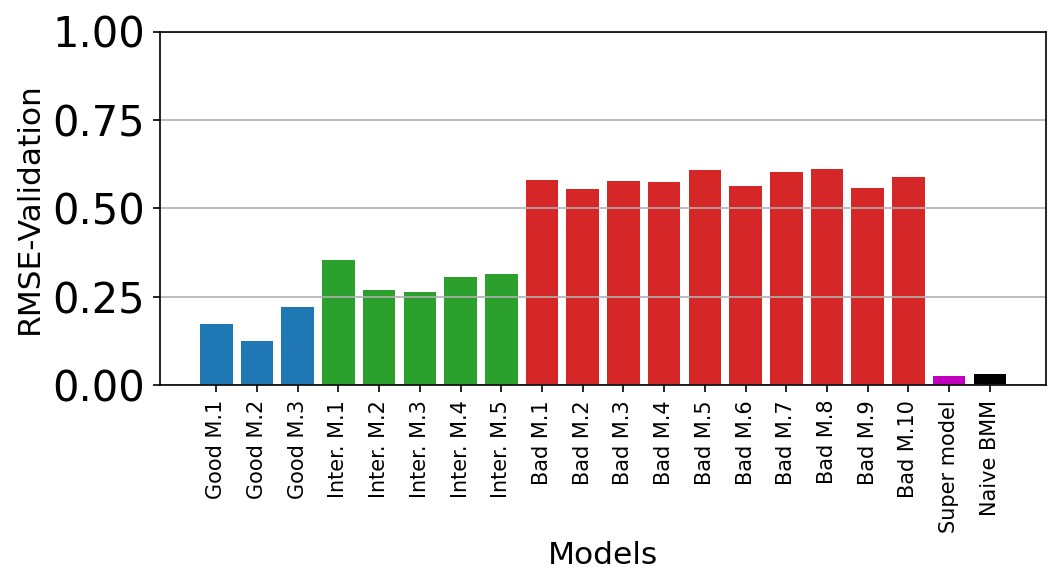

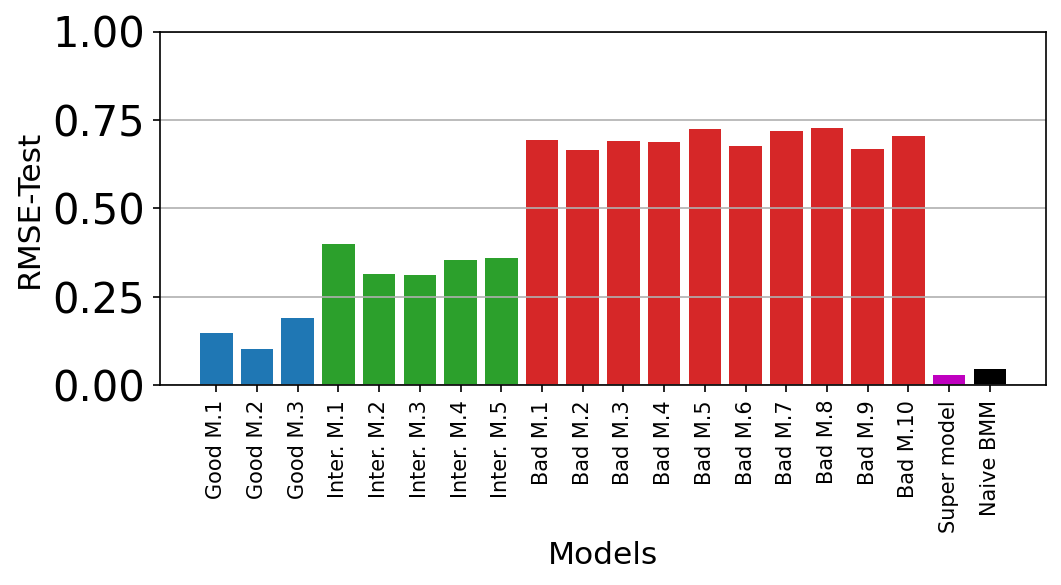

In [77]:
y_max=1

plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


################################

# Training round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)
# plt.figure(dpi=150)

rmse_train=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        # ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], 
        #         label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_train"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_train"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_train.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_train, color='m')
plt.bar('Naive BMM' , sigma_naive_train, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Train',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Validation round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)
# plt.figure(dpi=150)

rmse_validation=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_validation"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_validation"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_validation.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_validation, color='m')

plt.bar('Naive BMM' , sigma_naive_validation, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Validation',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Testing round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)
# plt.figure(dpi=150)

rmse_test=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_test"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_test"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_test.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_test, color='m')
plt.bar('Naive BMM' , sigma_naive_test, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Test',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Everything round

In [78]:
def PC_RMSE_calculator(components_kept):  #A function that will basically run everything above (without the plots) with varying number of kept PCs




    S_hat=np.array([S[i] for i in range(components_kept)])

    # U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])
    U_hat=np.array([U.T[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])

    # Vt_hat=np.array([Vt[i] for i in range(components_kept)])
    Vt_hat=np.array([Vt[i]/S_hat[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])   


    if centering_data:
        num_components=components_kept+1
    else:
        num_components=components_kept



    #########################################
    #Creating principal components that are for training. These should be equivalent to \hat U, and if they are not there is something wrong
    models_PC_train = {}
    if centering_data:
        models_PC_train[str("PC_0")] = predictions_train_mean       
    for i in range(components_kept):
        models_PC_train[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_train.T)
    models_PC_train["N"] = models_output_train["N"]
    models_PC_train["Z"] = models_output_train["Z"]
    models_PC_train["A"] = models_PC_train["N"] + models_PC_train["Z"]
    models_PC_training = pd.DataFrame(models_PC_train)
    #########################################

    #########################################
    #Creating principal components that are for validation
    models_PC_validation = {}
    if centering_data:
        models_PC_validation[str("PC_0")] = predictions_validation_mean
    for i in range(components_kept):
        models_PC_validation[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_validation.T)
    models_PC_validation["N"] = models_output_validation["N"]
    models_PC_validation["Z"] = models_output_validation["Z"]
    models_PC_validation["A"] = models_PC_validation["N"] + models_PC_validation["Z"]
    models_PC_validation = pd.DataFrame(models_PC_validation)
    #########################################

    #########################################
    #Creating principal components that are for testing
    models_PC_testing = {}
    if centering_data:
        models_PC_testing[str("PC_0")] = predictions_test_mean
    for i in range(components_kept):
        # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
        models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

    models_PC_testing["N"] = models_output_test["N"]
    models_PC_testing["Z"] = models_output_test["Z"]
    models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]
    models_PC_testing = pd.DataFrame(models_PC_testing)
    #########################################

    #Creating principal components that are valid everywhere (testing + training + validation)
    models_PC = {}
    if centering_data:
        models_PC[str("PC_0")] = predictions_mean
    for i in range(components_kept):
        models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)
    models_PC = pd.DataFrame(models_PC)
    models_PC["N"] = Full_set.T[0]
    models_PC["Z"] = Full_set.T[1]
    models_PC["A"] = models_PC["N"] + models_PC["Z"]
    #########################################

    key_list_PCs=list(models_PC_testing.keys())


    X=np.copy(U_hat)
    if centering_data:
        y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean
    else:
        y=np.copy(models_output_train["truth"].tolist())
    #Making the list of principal components across the train part. These should be identical to the X on top made by \hat U
    X_train=[]
    for i in range(num_components):
        X_train.append(models_PC_train[key_list_PCs[i]].tolist())
    X_train=np.array(X_train)
    #Making the list of principal components across the validation part
    X_validation=[]
    for i in range(num_components):
        X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
    X_validation=np.array(X_validation)

    #Making the list of principal components across the testing part
    X_test=[]
    for i in range(num_components):
        X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
    X_test=np.array(X_test)
    #Making the list of principal components across the entire chart (training+validation+testing)
    X_full=[]
    for i in range(num_components):
        X_full.append(models_PC[key_list_PCs[i]].tolist())
    X_full=np.array(X_full)

    

    # 1) Find the least square solution for the training part
    X_T_X_inv = np.linalg.inv(X.dot(X.T))
    beta = X_T_X_inv.dot(X).dot(y)
    
    #1.5) Construct the super model across the entire range and the test range
    if centering_data:
        beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
    else:
        beta_full=np.copy(beta)

    # supermodel=X.T.dot(beta_full)
    supermodel=X_train.T.dot(beta_full)
    supermodel_train=np.copy(supermodel)
    supermodel_validation=X_validation.T.dot(beta_full)
    supermodel_test=X_test.T.dot(beta_full)
    supermodel_full=X_full.T.dot(beta_full)

    
    super_model_resituals_train=supermodel_train-models_output_train['truth'].tolist()
    super_model_residuals_validation= supermodel_validation-models_output_validation['truth'].tolist()
    super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()
    super_model_residuals_full = supermodel_full-models_output['truth'].tolist()

    sigma_train=np.sqrt(np.sum(super_model_resituals_train**2) / len(super_model_resituals_train) )
    sigma_validation=np.sqrt(np.sum(super_model_residuals_validation**2) / len(super_model_residuals_validation) )
    sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )
    sigma_full=np.sqrt(np.sum(super_model_residuals_full**2) / len(super_model_residuals_full) )


    return [sigma_train,sigma_validation,sigma_test,sigma_full]

In [79]:
if centering_data:
    s_validation=[np.linalg.norm(np.array(models_output_validation["truth"].tolist())-predictions_validation_mean)/np.sqrt(len(predictions_validation_mean))]
    s_test=[np.linalg.norm(np.array(models_output_test["truth"].tolist())-predictions_test_mean)/np.sqrt(len(predictions_test_mean))]
    s_train=[np.linalg.norm(np.array(models_output_train["truth"].tolist())-predictions_train_mean)/np.sqrt(len(predictions_train_mean))]
    s_all=[np.linalg.norm(np.array(models_output["truth"].tolist())-predictions_mean)/np.sqrt(len(predictions_mean))]
    
else:
    s_test=[]
    s_train=[]
    s_validation=[]
    s_all=[]

for i in range(1,len(S)):
    res=PC_RMSE_calculator(i)
    s_train.append(res[0])
    s_validation.append(res[1])
    s_test.append(res[2])
    
    s_all.append(res[3])

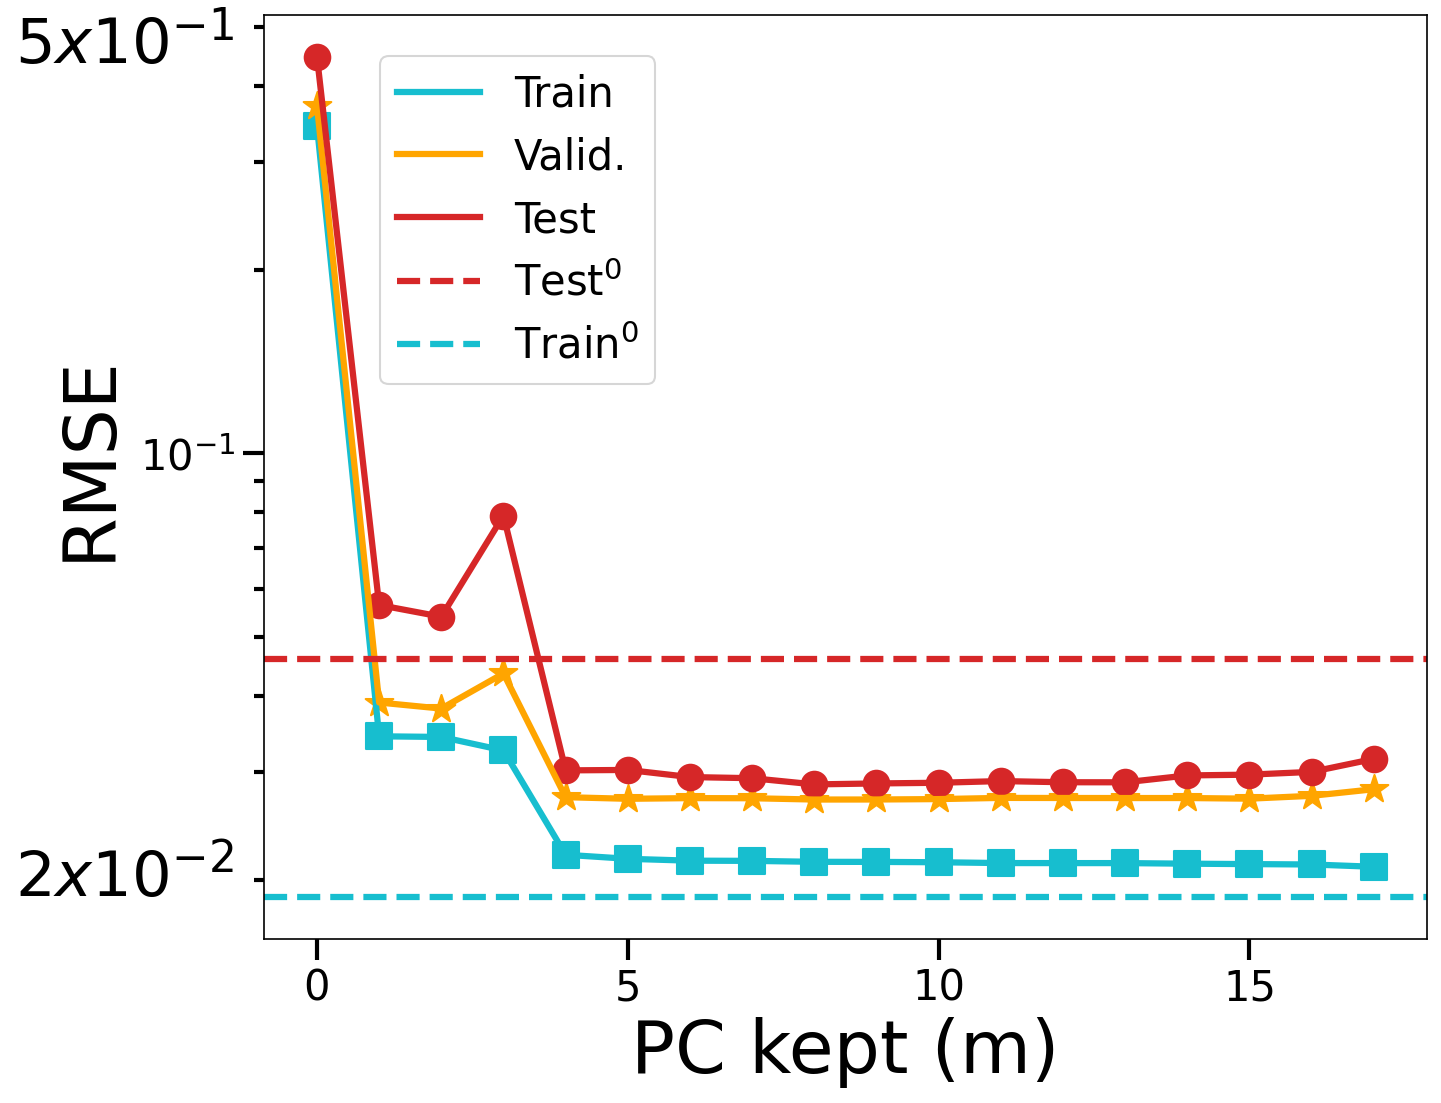

In [80]:
# plt.rc("xtick", labelsize=30)
# plt.rc("ytick", labelsize=30)


fig, ax = plt.subplots(figsize=(10,8),dpi=150)
fig.patch.set_facecolor('white')


# color_trainig=colors[9]
# color_validation='orange'
# color_testing=colors[3]

# marker_trainig='s'
# marker_validation='*'
# marker_testing='o'



# size_trainig=30
# size_validation=80
# size_testing=35

# alpha_trainig=0.8
# alpha_validation=0.9
# alpha_testing=0.4



size_points=150



ax.scatter(np.arange(0,len(s_train)), s_train,color=color_trainig,s=size_points,marker=marker_trainig)
ax.plot(np.arange(0,len(s_train)), s_train,color=color_trainig,linewidth=3,label="Train")

ax.scatter(np.arange(0,len(s_validation)), s_validation,color=color_validation,s=size_points*1.3,marker=marker_validation)
ax.plot(np.arange(0,len(s_validation)), s_validation,color=color_validation,linewidth=3,label="Valid.")


ax.scatter(np.arange(0,len(s_test)), s_test,color=color_testing,s=size_points,marker=marker_testing)
ax.plot(np.arange(0,len(s_test)), s_test,color=color_testing,linewidth=3,label="Test")

# ax.scatter(np.arange(1,len(s_all)+1), s_all,color='k',s=90,marker="s")
# ax.plot(np.arange(1,len(s_all)+1), s_all,color='k',linewidth=3,label="All",linestyle='dashed')

ax.axhline(y=sigma_naive_test,color=color_testing,label="Test$^0$",linestyle='dashed',linewidth=3)

ax.axhline(y=sigma_naive_train,color=color_trainig,label=f"Train$^0$",linestyle='dashed',linewidth=3)


ax.set_yscale('log')
ax.set_xlabel(r'PC kept (m)',fontsize=35)
ax.set_ylabel(r' RMSE',fontsize=35);
ax.set_xticks([0,5,10,15])
# ax.set_yticks()
# plt.ylim(1.7*10**(-2),1)

# plt.title("Singular values decay",fontsize=30)

plt.tick_params(axis='both',       
            which='major',      
            length=10,        
            width=2)

plt.tick_params(axis='both',       
            which='minor',      
            length=5,        
            width=2) 

plt.annotate(f'$5 x 10^{{-1}}$', xy=(-0.12,1), xycoords='axes fraction',
             ha='center', va='top', fontsize=30) 

plt.annotate(f'$2 x 10^{{-2}}$', xy=(-0.12,0.1), xycoords='axes fraction',
             ha='center', va='top', fontsize=30) 



plt.legend(fontsize=20,loc=(0.1,0.6))
plt.show()

In [81]:
# s_test_Centering=np.copy(s_test)
# s_train_Centering=np.copy(s_train)
# s_validation_Centering=np.copy(s_validation)
# s_all_Centering=np.copy(s_all)


In [82]:
# s_test_NO_Centering=np.copy(s_test)
# s_train_NO_Centering=np.copy(s_train)
# s_validation_NO_Centering=np.copy(s_validation)
# s_all_NO_Centering=np.copy(s_all)


In [83]:
# plt.rc("xtick", labelsize=20)
# plt.rc("ytick", labelsize=20)


# fig, ax = plt.subplots(figsize=(10,10),dpi=150)
# fig.patch.set_facecolor('white')



# #Centering

# ax.scatter(np.arange(0,len(s_train)), s_train_Centering,color=colors[0],s=90,marker="s",label="Training (Centering)")
# ax.plot(np.arange(0,len(s_train)), s_train_Centering,color=colors[0],linewidth=3)

# # ax.scatter(np.arange(0,len(s_validation)), s_validation_Centering,color=colors[0],s=90,marker="o",label="Validation (Centering)")
# # ax.plot(np.arange(0,len(s_validation)), s_validation_Centering,color=colors[0],linewidth=3)


# ax.scatter(np.arange(0,len(s_test)), s_test_Centering,color=colors[0],s=90,marker="*",label="Testing (Centering)")
# ax.plot(np.arange(0,len(s_test)), s_test_Centering,color=colors[0],linewidth=3)

# # ax.scatter(np.arange(0,len(s_all)), s_all_Centering,color=colors[0],s=90,marker="s",label="All (Centering)")
# # ax.plot(np.arange(0,len(s_all)), s_all_Centering,color=colors[0],linewidth=3,linestyle='dashed')




# # #NoCentering


# ax.scatter(np.arange(1,len(s_train_NO_Centering)+1), s_train_NO_Centering,color=colors[1],s=90,marker="s",label="Training (NO-Centering)")
# ax.plot(np.arange(1,len(s_train_NO_Centering)+1), s_train_NO_Centering,color=colors[1],linewidth=3)

# # ax.scatter(np.arange(1,len(s_validation_NO_Centering)+1), s_validation_NO_Centering,color=colors[1],s=90,marker="o",label="Validation (NO-Centering)")
# # ax.plot(np.arange(1,len(s_validation_NO_Centering)+1), s_validation_NO_Centering,color=colors[1],linewidth=3)


# ax.scatter(np.arange(1,len(s_test_NO_Centering)+1), s_test_NO_Centering,color=colors[1],s=90,marker="*",label="Testing (NO-Centering)")
# ax.plot(np.arange(1,len(s_test_NO_Centering)+1), s_test_NO_Centering,color=colors[1],linewidth=3)

# # ax.scatter(np.arange(1,len(s_all_NO_Centering)+1), s_all_NO_Centering,color=colors[1],s=90,marker="s",label="All (NO-Centering)")
# # ax.plot(np.arange(1,len(s_all_NO_Centering)+1), s_all_NO_Centering,color=colors[1],linewidth=3,linestyle='dashed')



# ax.axhline(y=sigma_naive_test,color='k',label="Naive BMM - Test")

# ax.axhline(y=sigma_naive_train,color='r',label="Naive BMM - Train")








# ax.set_yscale('log')
# ax.set_xlabel(r'Principal Components kept',fontsize=20)
# ax.set_ylabel(r' RMSE',fontsize=20);
# # ax.set_xticks([0,5,10,15])

# # plt.ylim(3*10**(-3),0.7)

# # plt.title("Singular values decay",fontsize=30)
# plt.legend(fontsize=20)
# plt.show()

NameError: name 's_train_Centering' is not defined

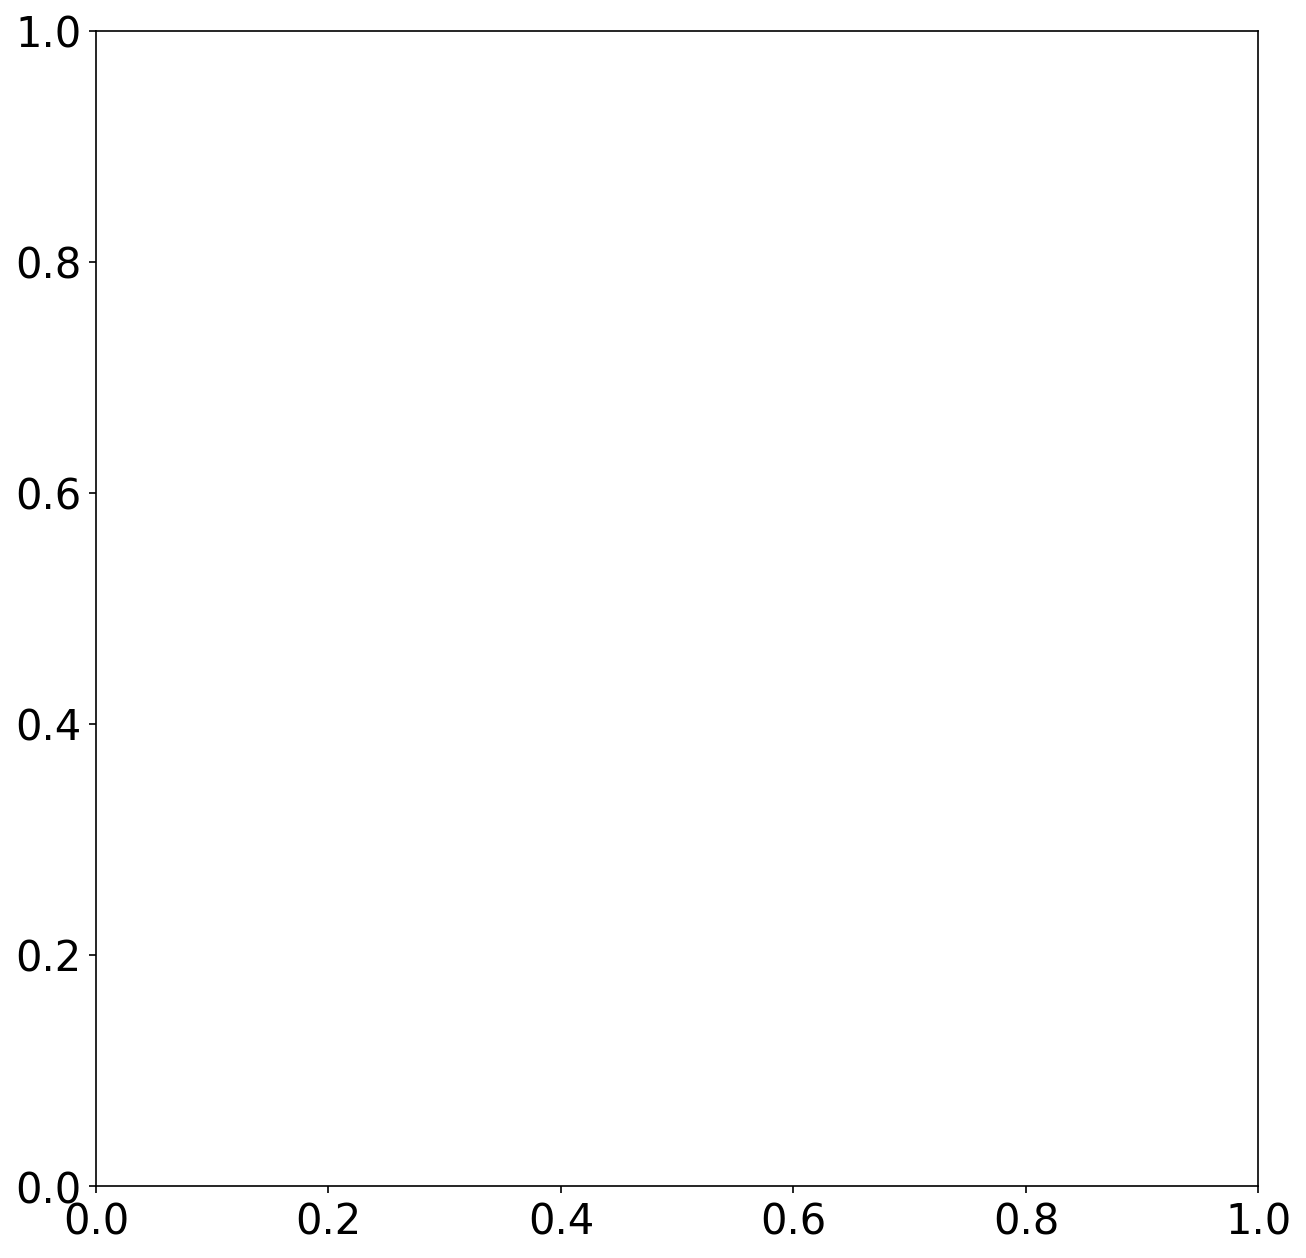

In [84]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(figsize=(10,10),dpi=150)
fig.patch.set_facecolor('white')



#Centering

ax.scatter(np.arange(0,len(s_train_Centering)), s_train_Centering,color=colors[0],s=90,marker="s",label="Training (Centering)")
ax.plot(np.arange(0,len(s_train_Centering)), s_train_Centering,color=colors[0],linewidth=3)

# ax.scatter(np.arange(0,len(s_validation)), s_validation_Centering,color=colors[0],s=90,marker="o",label="Validation (Centering)")
# ax.plot(np.arange(0,len(s_validation)), s_validation_Centering,color=colors[0],linewidth=3)


ax.scatter(np.arange(0,len(s_test_Centering)), s_test_Centering,color=colors[0],s=90,marker="*",label="Testing (Centering)")
ax.plot(np.arange(0,len(s_test_Centering)), s_test_Centering,color=colors[0],linewidth=3)

# ax.scatter(np.arange(0,len(s_all)), s_all_Centering,color=colors[0],s=90,marker="s",label="All (Centering)")
# ax.plot(np.arange(0,len(s_all)), s_all_Centering,color=colors[0],linewidth=3,linestyle='dashed')




# #NoCentering


ax.scatter(np.arange(1,len(s_train_NO_Centering)+1), s_train_NO_Centering,color=colors[1],s=90,marker="s",label="Training (NO-Centering)")
ax.plot(np.arange(1,len(s_train_NO_Centering)+1), s_train_NO_Centering,color=colors[1],linewidth=3)

# ax.scatter(np.arange(1,len(s_validation_NO_Centering)+1), s_validation_NO_Centering,color=colors[1],s=90,marker="o",label="Validation (NO-Centering)")
# ax.plot(np.arange(1,len(s_validation_NO_Centering)+1), s_validation_NO_Centering,color=colors[1],linewidth=3)


ax.scatter(np.arange(1,len(s_test_NO_Centering)+1), s_test_NO_Centering,color=colors[1],s=90,marker="*",label="Testing (NO-Centering)")
ax.plot(np.arange(1,len(s_test_NO_Centering)+1), s_test_NO_Centering,color=colors[1],linewidth=3)

# ax.scatter(np.arange(1,len(s_all_NO_Centering)+1), s_all_NO_Centering,color=colors[1],s=90,marker="s",label="All (NO-Centering)")
# ax.plot(np.arange(1,len(s_all_NO_Centering)+1), s_all_NO_Centering,color=colors[1],linewidth=3,linestyle='dashed')



ax.axhline(y=sigma_naive_test,color='k',label="Naive BMM - Test")

ax.axhline(y=sigma_naive_train,color='r',label="Naive BMM - Train")








ax.set_yscale('log')
ax.set_xlabel(r'Principal Components kept',fontsize=20)
ax.set_ylabel(r' RMSE',fontsize=20);
# ax.set_xticks([0,5,10,15])

# plt.ylim(3*10**(-3),0.7)

# plt.title("Singular values decay",fontsize=30)
plt.legend(fontsize=20)
plt.show()